# Coursera Capstone Project - Predicting the Concentration of Starbucks Locations using Socioeconomic Data

__Created By:__ Trevor Stull

__Updated On:__ 2/22/2020

## 1. Importing Libraries Needed for the Project

In [867]:
import json # library to handle JSON files

import pandas as pd # table manipulation library

import numpy as np # library for analyzing data

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install folium 
import folium # map rendering library

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns # for data visualization

import requests # library to handle requests

# import the visualization package: seaborn
import seaborn as sns
%matplotlib inline 

## 2. Searching for Starbucks in Dallas County

Dallas County was split into 256 equal sized quadrants which will be used to search for Starbucks locations in Dallas County. Each quadrant was assigned a point in the center of it with latitude and longitude information, which will be used along with Fourspaure's search tool. This data was prepared using geographic information systems (GIS).

### The following code shows the 256 points that will be used to search for Starbucks in Dallas County.

In [7]:
dallas_county_sps_filepath = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Search Points/Dallas_County_SPs.xls'

In [8]:
print(dallas_county_sps_filepath)

C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Search Points/Dallas_County_SPs.xls


In [13]:
!conda install -c anaconda xlrd --yes
df_dallas_sps = pd.read_excel(dallas_county_sps_filepath)

print ('Data read into a pandas dataframe!')

Solving environment: ...working... done

# All requested packages already installed.

Data read into a pandas dataframe!


__Removing FID and ID columns from data set.__

In [16]:
df_dallas_sps = df_dallas_sps.drop([df_dallas_sps.columns[0], df_dallas_sps.columns[1]],axis='columns')

In [19]:
df_dallas_sps.head()

,Lat,Long
0,32.559206,-97.028924
1,32.558810,-96.995876
2,32.558405,-96.962828
3,32.557991,-96.929781
4,32.557568,-96.896733


In [53]:
address = 'Dallas, Texas'

geolocator = Nominatim(user_agent="dallas_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dallas are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dallas are 32.7762719, -96.7968559.


In [83]:
# create map of Dallas using latitude and longitude values
map_dallas = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng in zip(df_dallas_sps['Lat'], df_dallas_sps['Long']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dallas)  
    
map_dallas

### Searching for Starbucks in Dallas County

__Foursquare API credentials. This information will be used for locating Starbucks in Tarrant County.__

In [30]:
CLIENT_ID = 'HYC0O0YMBRQLDDZHGDVWO3BTHGITXO0G0GKN4N1WBWIEGYNP' # your Foursquare ID
CLIENT_SECRET = 'VB0A4ZQYSKGIPBA53EFJ33EA13QMBRY1VUR0NBIBMWJ0EMCQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 800 # number of venues searched
radius = 3000 # searcg radius in meters to use
query = 'Starbucks'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HYC0O0YMBRQLDDZHGDVWO3BTHGITXO0G0GKN4N1WBWIEGYNP
CLIENT_SECRET:VB0A4ZQYSKGIPBA53EFJ33EA13QMBRY1VUR0NBIBMWJ0EMCQ


__Searching function that will also be used for to find Tarrant County Starbucks.__

In [66]:
#function to look up venues around each neighborhood.
def getNearbyVenues(latitudes, longitudes):
    
    search_count = 1
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
        print(search_count)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            query)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                address = v['location']['address']
            except:
                address = 'No Address.'
            try:
                postalcode = v['location']['postalCode']
            except:
                postalcode = 'No Post Code.'
            try:
                city = v['location']['city']
            except:
                city = 'No City.'
            venues_list.append([
                v['name'], 
                address,
                city,
                postalcode,
                v['location']['lat'],
                v['location']['lng']])
        
        search_count = search_count + 1 # increasing the counter

    nearby_venues = pd.DataFrame([venue_list for venue_list in venues_list])
    nearby_venues.columns = ['Venue',
                  'Venue Address', 
                  'Venue City', 
                  'Venue Postal Code',
                  'Venue Latitude',
                  'Venue Longitude']
    
    return(nearby_venues)

__Calling search function for Dallas County Search Points__

In [69]:
dallas_county_starbucks = getNearbyVenues(df_dallas_sps['Lat'], df_dallas_sps['Long'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


Showing the output of the Starbucks search in Dallas County.

In [82]:
dallas_county_starbucks.head(15)

,Venue,Venue Address,Venue City,Venue Postal Code,Venue Latitude,Venue Longitude
0,Starbucks,455 E FM 1382,Cedar Hill,75104,32.591293,-96.935670
1,Starbucks,160 North I-35,Lancaster,75146,32.555389,-96.822531
2,Starbucks Red Oak,No Address.,Red Oak,75154,32.532600,-96.820726
3,Starbucks,160 North I-35,Lancaster,75146,32.555389,-96.822531
4,Starbucks,455 E FM 1382,Cedar Hill,75104,32.591293,-96.935670
5,Starbucks,739 N Highway 67,Cedar Hill,75104,32.602709,-96.936701
6,Starbucks,305 W FM 1382,Cedar Hill,75104,32.602169,-96.942251
7,Barnes & Noble Café,No Address.,Cedar Hill,75104,32.602116,-96.942612
8,Starbucks,455 E FM 1382,Cedar Hill,75104,32.591293,-96.935670
9,Starbucks,739 N Highway 67,Cedar Hill,75104,32.602709,-96.936701


As seen above, some of the Starbucks were recorded more than once. To ensure Starbucks locations were not double counted, only unique Starbucks latitudes and longitudes were used. The .groupby() function was used to return the unique Starbucks locations.

In [73]:
dallas_county_starbucks_unique = dallas_county_starbucks.groupby(['Venue Latitude', 'Venue Longitude'], as_index=False).first()

In [79]:
dallas_county_starbucks_unique.head()

,Venue Latitude,Venue Longitude,Venue,Venue Address,Venue City,Venue Postal Code
0,32.532600,-96.820726,Starbucks Red Oak,No Address.,Red Oak,75154
1,32.555389,-96.822531,Starbucks,160 North I-35,Lancaster,75146
2,32.591293,-96.935670,Starbucks,455 E FM 1382,Cedar Hill,75104
3,32.602116,-96.942612,Barnes & Noble Café,No Address.,Cedar Hill,75104
4,32.602169,-96.942251,Starbucks,305 W FM 1382,Cedar Hill,75104


In [80]:
print(dallas_county_starbucks_unique.shape)

(253, 6)


Mapping the unique Starbucks locations.

In [119]:
# create map of Manhattan using latitude and longitude values
map_dallas = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng in zip(dallas_county_starbucks_unique['Venue Latitude'], dallas_county_starbucks_unique['Venue Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dallas)  
    
map_dallas

## 3. Searching for Starbucks in Tarrant County

### The following code shows the 256 points that will be used to search for Starbucks in Tarrant County.

In [88]:
tarrant_county_sps_filepath = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Search Points/Tarrant_County_SPs.xls'

In [91]:
print(tarrant_county_sps_filepath)

C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Search Points/Tarrant_County_SPs.xls


In [95]:
df_tarrant_sps = pd.read_excel(tarrant_county_sps_filepath)

print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


__Removing FID and ID columns from data set.__

In [96]:
df_tarrant_sps = df_tarrant_sps.drop([df_tarrant_sps.columns[0], df_tarrant_sps.columns[1]],axis='columns')

In [97]:
df_tarrant_sps.head()

,Lat,Long
0,32.562652,-97.538840
1,32.562394,-97.506148
2,32.562128,-97.473456
3,32.561853,-97.440765
4,32.561570,-97.408073


In [98]:
address = 'Fort Worth, Texas'

geolocator2 = Nominatim(user_agent="fort_worth_explorer")
location2 = geolocator2.geocode(address)
latitude2 = location2.latitude
longitude2 = location2.longitude
print('The geograpical coordinate of Fort Worth are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinate of Fort Worth are 32.753177, -97.3327459.


In [100]:
# create map of Fort Worth using latitude and longitude values
map_fortworth = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# add markers to map
for lat, lng in zip(df_tarrant_sps['Lat'], df_tarrant_sps['Long']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fortworth)  
    
map_fortworth

### Searching for Starbucks in Tarrant County

__Calling search function for Tarrant County Search Points__

In [101]:
tarrant_county_starbucks = getNearbyVenues(df_tarrant_sps['Lat'], df_tarrant_sps['Long'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


Showing the output of the Starbucks search in Tarrant County.

In [102]:
tarrant_county_starbucks.head(15)

,Venue,Venue Address,Venue City,Venue Postal Code,Venue Latitude,Venue Longitude
0,Starbucks,626 E FM 1187,Crowley,76036,32.565721,-97.349579
1,Starbucks,833 NE Alsbury Blvd,Burleson,76028,32.565058,-97.322184
2,Starbucks,626 E FM 1187,Crowley,76036,32.565721,-97.349579
3,Albertsons,833 NE Alsbury Blvd,Burleson,76028,32.565038,-97.322219
4,Starbucks,833 NE Alsbury Blvd,Burleson,76028,32.565058,-97.322184
5,Starbucks,626 E FM 1187,Crowley,76036,32.565721,-97.349579
6,Albertsons,833 NE Alsbury Blvd,Burleson,76028,32.565038,-97.322219
7,Starbucks,980 US-287 N,Mansfield,76063,32.582444,-97.128841
8,Starbucks,3240 E Broad St,Mansfield,76063,32.573710,-97.083564
9,Starbucks,980 US-287 N,Mansfield,76063,32.582444,-97.128841


As seen above, some of the Starbucks were recorded more than once. To ensure Starbucks locations were not double counted, only unique Starbucks latitudes and longitudes were used. The .groupby() function was used to return the unique Starbucks locations.

In [106]:
tarrant_county_starbucks_unique = tarrant_county_starbucks.groupby(['Venue Latitude', 'Venue Longitude'], as_index=False).first()

In [107]:
tarrant_county_starbucks_unique.head()

,Venue Latitude,Venue Longitude,Venue,Venue Address,Venue City,Venue Postal Code
0,32.565038,-97.322219,Albertsons,833 NE Alsbury Blvd,Burleson,76028
1,32.565058,-97.322184,Starbucks,833 NE Alsbury Blvd,Burleson,76028
2,32.565721,-97.349579,Starbucks,626 E FM 1187,Crowley,76036
3,32.573710,-97.083564,Starbucks,3240 E Broad St,Mansfield,76063
4,32.582444,-97.128841,Starbucks,980 US-287 N,Mansfield,76063


In [108]:
print(tarrant_county_starbucks_unique.shape)

(186, 6)


Mapping the unique Starbucks locations.

In [931]:
# create map of Fort Worth using latitude and longitude values
map_fortworth = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# add markers to map
for lat, lng in zip(tarrant_county_starbucks_unique['Venue Latitude'], tarrant_county_starbucks_unique['Venue Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fortworth)  
    
map_fortworth

## 4. Preparing Data for Analysis

Saving Starbucks locations for both Dallas and Tarrant Counties as csvs, so they can be imported to GIS and used to determine Starbucks counts in each census tract.

In [115]:
tarrant_starbucks_path = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Starbucks Locations/Tarrant_County_Starbucks.csv'

In [116]:
tarrant_county_starbucks_unique.to_csv(path_or_buf = tarrant_starbucks_path)

In [117]:
dallas_starbucks_path = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Starbucks Locations/Dallas_County_Starbucks.csv'

In [118]:
dallas_county_starbucks_unique.to_csv(path_or_buf = dallas_starbucks_path)

The data above was manipulated in GIS to determine the Starbucks counts in each census tract in both Dallas and Tarrant county. The following excels were created as a process.

In [121]:
dallas_starbucks_counts_path = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Starbucks Counts/Dallas_County_Starbucks_Counts.xls'
print(dallas_starbucks_counts_path)

C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Starbucks Counts/Dallas_County_Starbucks_Counts.xls


In [246]:
df_dallas_starbucks_counts = pd.read_excel(dallas_starbucks_counts_path)
df_dallas_starbucks_counts.head()

,FID,FID_1,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Shape_Leng,Shape_Area,Count_
0,0,0,1,48,113,14133,48113014133,141.33,Census Tract 141.33,G5020,S,3799929,0,32.870104,-97.002971,37943.691367,4.089194e+07,0
1,1,1,2,48,113,980000,48113980000,9800.00,Census Tract 9800,G5020,S,27184723,1289,32.889235,-97.012816,127815.682718,2.925545e+08,1
2,2,2,3,48,113,14134,48113014134,141.34,Census Tract 141.34,G5020,S,2372276,225379,32.980471,-96.985403,23035.626968,2.795371e+07,1
3,3,3,4,48,113,14135,48113014135,141.35,Census Tract 141.35,G5020,S,1696549,27228,32.973643,-96.982513,18254.258738,1.854981e+07,2
4,4,4,5,48,113,14131,48113014131,141.31,Census Tract 141.31,G5020,S,912107,0,32.933413,-96.948675,13315.934068,9.815360e+06,0


### Preparing Starbucks Count Data

Removing unnecessary columns from the Starbucks count data frame for Dallas County.

In [247]:
df_dallas_starbucks_counts.columns

Index(['FID', 'FID_1', 'OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10',
       'GEOID10', 'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'Shape_Leng', 'Shape_Area',
       'Count_'],
      dtype='object')

In [248]:
Col_Index_to_Drop = [0,1,2,7,8,9,10,11,12,13,14,15,16]
Col_Name_to_Drop = []
for col_index in Col_Index_to_Drop:
    Col_Name_to_Drop.append(df_dallas_starbucks_counts.columns[col_index])
Col_Name_to_Drop

['FID',
 'FID_1',
 'OBJECTID',
 'NAME10',
 'NAMELSAD10',
 'MTFCC10',
 'FUNCSTAT10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10',
 'Shape_Leng',
 'Shape_Area']

In [249]:
df_dallas_starbucks_counts = df_dallas_starbucks_counts.drop(Col_Name_to_Drop, axis='columns')
df_dallas_starbucks_counts.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,Count_
0,48,113,14133,48113014133,0
1,48,113,980000,48113980000,1
2,48,113,14134,48113014134,1
3,48,113,14135,48113014135,2
4,48,113,14131,48113014131,0


Renaiming Count_ column name to Starbucks_Count.

In [250]:
df_dallas_starbucks_counts.rename(columns = {'Count_':'Starbucks_Count'}, inplace = True)
df_dallas_starbucks_counts.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,Starbucks_Count
0,48,113,14133,48113014133,0
1,48,113,980000,48113980000,1
2,48,113,14134,48113014134,1
3,48,113,14135,48113014135,2
4,48,113,14131,48113014131,0


Completing the same processes with Tarrant county Starbucks counts.

In [137]:
tarrant_starbucks_counts_path = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Starbucks Counts/Tarrant_County_Starbucks_Counts.xls'
print(tarrant_starbucks_counts_path)

C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Starbucks Counts/Tarrant_County_Starbucks_Counts.xls


In [242]:
df_tarrant_starbucks_counts = pd.read_excel(tarrant_starbucks_counts_path)
df_tarrant_starbucks_counts.head()

,FID,FID_1,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Count_
0,0,0,48,439,105007,48439105007,1050.07,Census Tract 1050.07,G5020,S,5002472,143500,32.851126,-97.306033,2
1,1,1,48,439,113926,48439113926,1139.26,Census Tract 1139.26,G5020,S,43571710,177118,32.925948,-97.325915,3
2,2,2,48,439,105008,48439105008,1050.08,Census Tract 1050.08,G5020,S,5187869,0,32.849997,-97.325065,1
3,3,3,48,439,114008,48439114008,1140.08,Census Tract 1140.08,G5020,S,15243552,49599,32.854865,-97.391289,1
4,4,4,48,439,105902,48439105902,1059.02,Census Tract 1059.02,G5020,S,5775052,127748,32.679096,-97.292928,0


In [243]:
Col_Index_to_Drop = [0,1,6,7,8,9,10,11,12,13]
Col_Name_to_Drop = []
for col_index in Col_Index_to_Drop:
    Col_Name_to_Drop.append(df_tarrant_starbucks_counts.columns[col_index])
Col_Name_to_Drop

['FID',
 'FID_1',
 'NAME10',
 'NAMELSAD10',
 'MTFCC10',
 'FUNCSTAT10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10']

In [244]:
df_tarrant_starbucks_counts = df_tarrant_starbucks_counts.drop(Col_Name_to_Drop, axis='columns')
df_tarrant_starbucks_counts.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,Count_
0,48,439,105007,48439105007,2
1,48,439,113926,48439113926,3
2,48,439,105008,48439105008,1
3,48,439,114008,48439114008,1
4,48,439,105902,48439105902,0


In [245]:
df_tarrant_starbucks_counts.rename(columns = {'Count_':'Starbucks_Count'}, inplace = True)
df_tarrant_starbucks_counts.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,Starbucks_Count
0,48,439,105007,48439105007,2
1,48,439,113926,48439113926,3
2,48,439,105008,48439105008,1
3,48,439,114008,48439114008,1
4,48,439,105902,48439105902,0


## Preparing the Census data for Analysis

### Total Population Data

Reading csv file.

In [147]:
totalPop_path = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Census Data/Total_Population/Total_Population.csv'
print(totalPop_path)

C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Census Data/Total_Population/Total_Population.csv


In [153]:
df_totalPop = pd.read_csv(totalPop_path, encoding='latin-1')
df_totalPop.head()

C:\Users\trevo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,SDELMA,SDSECA,SDUNIA,PUMA5A,BTTRA,BTBGA,NAME_E,AHY1E001,NAME_M,AHY1M001
0,GIS Join Match Code,Data File Year,Region Code,Division Code,State Name,State Code,County Name,County Code,County Subdivision Code,Place Code,...,School District (Elementary)/Remainder Code,School District (Secondary)/Remainder Code,School District (Unified)/Remainder Code,Public Use Microdata Sample Area (PUMA) Code,Tribal Census Tract Code,Tribal Block Group Code,Estimates: Area Name,Estimates: Total,Margins of error: Area Name,Margins of error: Total
1,G0100010020100,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 201, Autauga County, Alabama",1845,"Census Tract 201, Autauga County, Alabama",199
2,G0100010020200,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 202, Autauga County, Alabama",2172,"Census Tract 202, Autauga County, Alabama",271
3,G0100010020300,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 203, Autauga County, Alabama",3385,"Census Tract 203, Autauga County, Alabama",400
4,G0100010020400,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 204, Autauga County, Alabama",4267,"Census Tract 204, Autauga County, Alabama",466


In [154]:
df_totalPop.columns

Index(['GISJOIN', 'YEAR', 'REGIONA', 'DIVISIONA', 'STATE', 'STATEA', 'COUNTY',
       'COUNTYA', 'COUSUBA', 'PLACEA', 'TRACTA', 'BLKGRPA', 'CONCITA',
       'AIANHHA', 'RES_ONLYA', 'TRUSTA', 'AITSCEA', 'ANRCA', 'CBSAA', 'CSAA',
       'METDIVA', 'NECTAA', 'CNECTAA', 'NECTADIVA', 'UAA', 'CDCURRA', 'SLDUA',
       'SLDLA', 'ZCTA5A', 'SUBMCDA', 'SDELMA', 'SDSECA', 'SDUNIA', 'PUMA5A',
       'BTTRA', 'BTBGA', 'NAME_E', 'AHY1E001', 'NAME_M', 'AHY1M001'],
      dtype='object')

Renaming columns based on first row of the csv.

In [173]:
table_size = len(df_totalPop.columns)
for col_ind in list(range(table_size)):
    col_name = df_totalPop.columns[col_ind]
    new_col_name = df_totalPop.iloc[0,col_ind]
    df_totalPop = df_totalPop.rename(columns={col_name:new_col_name})
df_totalPop.head()

,GIS Join Match Code,Data File Year,Region Code,Division Code,State Name,State Code,County Name,County Code,County Subdivision Code,Place Code,...,School District (Elementary)/Remainder Code,School District (Secondary)/Remainder Code,School District (Unified)/Remainder Code,Public Use Microdata Sample Area (PUMA) Code,Tribal Census Tract Code,Tribal Block Group Code,Estimates: Area Name,Estimates: Total,Margins of error: Area Name,Margins of error: Total
0,GIS Join Match Code,Data File Year,Region Code,Division Code,State Name,State Code,County Name,County Code,County Subdivision Code,Place Code,...,School District (Elementary)/Remainder Code,School District (Secondary)/Remainder Code,School District (Unified)/Remainder Code,Public Use Microdata Sample Area (PUMA) Code,Tribal Census Tract Code,Tribal Block Group Code,Estimates: Area Name,Estimates: Total,Margins of error: Area Name,Margins of error: Total
1,G0100010020100,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 201, Autauga County, Alabama",1845,"Census Tract 201, Autauga County, Alabama",199
2,G0100010020200,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 202, Autauga County, Alabama",2172,"Census Tract 202, Autauga County, Alabama",271
3,G0100010020300,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 203, Autauga County, Alabama",3385,"Census Tract 203, Autauga County, Alabama",400
4,G0100010020400,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 204, Autauga County, Alabama",4267,"Census Tract 204, Autauga County, Alabama",466


Dropping first row of csv.

In [174]:
df_totalPop = df_totalPop.drop(index=[0], axis=0)
df_totalPop.head()

,GIS Join Match Code,Data File Year,Region Code,Division Code,State Name,State Code,County Name,County Code,County Subdivision Code,Place Code,...,School District (Elementary)/Remainder Code,School District (Secondary)/Remainder Code,School District (Unified)/Remainder Code,Public Use Microdata Sample Area (PUMA) Code,Tribal Census Tract Code,Tribal Block Group Code,Estimates: Area Name,Estimates: Total,Margins of error: Area Name,Margins of error: Total
1,G0100010020100,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 201, Autauga County, Alabama",1845,"Census Tract 201, Autauga County, Alabama",199
2,G0100010020200,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 202, Autauga County, Alabama",2172,"Census Tract 202, Autauga County, Alabama",271
3,G0100010020300,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 203, Autauga County, Alabama",3385,"Census Tract 203, Autauga County, Alabama",400
4,G0100010020400,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 204, Autauga County, Alabama",4267,"Census Tract 204, Autauga County, Alabama",466
5,G0100010020500,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 205, Autauga County, Alabama",9965,"Census Tract 205, Autauga County, Alabama",802


Base columns to delete.

In [163]:
census_base_colIND_delete = [1,2,3,4,6,8,9]
for num in list(range(11,37)):
    census_base_colIND_delete.append(num)
census_base_colIND_delete

[1,
 2,
 3,
 4,
 6,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36]

Find Margin of Error columns and adding to list of deletions.

In [175]:
counter = 0
for col in df_totalPop.columns:
    if 'Margin' in col:
        census_base_colIND_delete.append(counter)
    counter = counter + 1 
census_base_colIND_delete

[1,
 2,
 3,
 4,
 6,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39]

Getting name of columns to delete.

In [176]:
census_base_colName_delete = []

In [177]:
for index in census_base_colIND_delete:
    census_base_colName_delete.append(df_totalPop.columns[index])
census_base_colName_delete

['Data File Year',
 'Region Code',
 'Division Code',
 'State Name',
 'County Name',
 'County Subdivision Code',
 'Place Code',
 'Block Group Code',
 'Consolidated City Code',
 'American Indian Area/Alaska Native Area/Hawaiian Home Land Code',
 'American Indian Area/Alaska Native Area (Reservation or Statistical Entity Only) Code',
 'American Indian Area (Off-Reservation Trust Land Only)/Hawaiian Home Land Code',
 'Tribal Subdivision/Remainder Code',
 'Alaska Native Regional Corporation Code',
 'Metropolitan Statistical Area/Micropolitan Statistical Area Code',
 'Combined Statistical Area Code',
 'Metropolitan Division Code',
 'New England City and Town Area Code',
 'Combined New England City and Town Area Code',
 'New England City and Town Area Division Code',
 'Urban Area Code',
 'Congressional District (2017-2019, 115th Congress) Code',
 'State Legislative District (Upper Chamber) Code',
 'State Legislative District (Lower Chamber) Code',
 '5-Digit ZIP Code Tabulation Area Code',
 'S

Deleting columns selected for deletion.

In [179]:
df_totalPop_clean = df_totalPop.drop(census_base_colName_delete, axis=1)
df_totalPop_clean.head()

,GIS Join Match Code,State Code,County Code,Census Tract Code,Estimates: Total
1,G0100010020100,01,001,020100,1845
2,G0100010020200,01,001,020200,2172
3,G0100010020300,01,001,020300,3385
4,G0100010020400,01,001,020400,4267
5,G0100010020500,01,001,020500,9965


Selecting Dallas and Tarrant County data.

In [188]:
state = df_totalPop_clean['State Code'] == 48
county = (df_totalPop_clean['County Code'] == 113) | (df_totalPop_clean['County Code'] == 439)
df_totalPop_clean_DT = df_totalPop_clean.loc[state & county]
df_totalPop_clean_DT.head()

,GIS Join Match Code,State Code,County Code,Census Tract Code,Estimates: Total
62665,G4801130000100,48,113,100,4105
62666,G4801130000201,48,113,201,2949
62667,G4801130000202,48,113,202,3857
62668,G4801130000300,48,113,300,4235
62669,G4801130000401,48,113,401,5755


### Function Definition for the Census Table Cleaning Process

In [213]:
def table_prep(table):
    # renames columns to first row entry
    table_size = len(table.columns)
    for col_ind in list(range(table_size)):
        col_name = table.columns[col_ind]
        new_col_name = table.iloc[0,col_ind]
        table = table.rename(columns={col_name:new_col_name})
    
    # removes first row from table
    table_temp = table.drop(index=[0], axis=0)
    
    # base columns to delete
    census_base_colIND_delete = [1,2,3,4,6,8,9]
    for num in list(range(11,37)):
        census_base_colIND_delete.append(num)
    
    # finding columns with Margin in the name
    counter = 0
    for col in table_temp.columns:
        if 'Margin' in col:
            census_base_colIND_delete.append(counter)
        counter = counter + 1 
    
    # Getting column names to delete
    census_base_colName_delete = []
    for index in census_base_colIND_delete:
        census_base_colName_delete.append(table_temp.columns[index])
    
    # Deleting columns 
    table_temp_clean = table_temp.drop(census_base_colName_delete, axis=1)
    
    # Selecting state and census tracts (Texas and Dallas or Tarrant Counties)
    state = table_temp_clean['State Code'] == 48
    county = (table_temp_clean['County Code'] == 113) | (table_temp_clean['County Code'] == 439)
    table_fin_clean = table_temp_clean.loc[state & county]
    
    return(table_fin_clean)

### Sex and Age Data Set

In [195]:
SexAge_path = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Census Data/Sex_Age/Sex_Age.csv'
print(SexAge_path)

C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Census Data/Sex_Age/Sex_Age.csv


In [196]:
df_SexAge = pd.read_csv(SexAge_path, encoding='latin-1')
df_SexAge.head()

C:\Users\trevo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,AHYQM040,AHYQM041,AHYQM042,AHYQM043,AHYQM044,AHYQM045,AHYQM046,AHYQM047,AHYQM048,AHYQM049
0,GIS Join Match Code,Data File Year,Region Code,Division Code,State Name,State Code,County Name,County Code,County Subdivision Code,Place Code,...,Margins of error: Female: 50 to 54 years,Margins of error: Female: 55 to 59 years,Margins of error: Female: 60 and 61 years,Margins of error: Female: 62 to 64 years,Margins of error: Female: 65 and 66 years,Margins of error: Female: 67 to 69 years,Margins of error: Female: 70 to 74 years,Margins of error: Female: 75 to 79 years,Margins of error: Female: 80 to 84 years,Margins of error: Female: 85 years and over
1,G0100010020100,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,39,43,34,11,20,26,25,16,10,32
2,G0100010020200,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,30,14,19,32,23,21,33,17,28,29
3,G0100010020300,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,35,51,26,47,49,49,69,56,24,40
4,G0100010020400,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,73,53,42,56,35,32,51,65,48,26


In [214]:
df_SexAge_clean_DT = table_prep(df_SexAge)
df_SexAge_clean_DT.head()

,GIS Join Match Code,State Code,County Code,Census Tract Code,Estimates: Total,Estimates: Male,Estimates: Male: Under 5 years,Estimates: Male: 5 to 9 years,Estimates: Male: 10 to 14 years,Estimates: Male: 15 to 17 years,...,Estimates: Female: 50 to 54 years,Estimates: Female: 55 to 59 years,Estimates: Female: 60 and 61 years,Estimates: Female: 62 to 64 years,Estimates: Female: 65 and 66 years,Estimates: Female: 67 to 69 years,Estimates: Female: 70 to 74 years,Estimates: Female: 75 to 79 years,Estimates: Female: 80 to 84 years,Estimates: Female: 85 years and over
62665,G4801130000100,48,113,100,4105,2009,209,137,125,23,...,188,134,54,80,80,48,42,17,8,20
62666,G4801130000201,48,113,201,2949,1381,131,129,40,33,...,111,77,55,31,6,48,71,0,23,23
62667,G4801130000202,48,113,202,3857,1866,122,124,137,31,...,117,142,38,32,29,28,29,32,28,26
62668,G4801130000300,48,113,300,4235,2363,231,76,65,30,...,51,193,55,25,43,15,20,0,79,23
62669,G4801130000401,48,113,401,5755,3129,212,113,165,53,...,78,159,7,42,6,4,64,9,23,28


### Race Data Set

In [216]:
Race_path = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Census Data/Race/Race.csv'
print(Race_path)

C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Census Data/Race/Race.csv


In [217]:
df_Race = pd.read_csv(Race_path, encoding='latin-1')
df_Race.head()

C:\Users\trevo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,AHZAM012,AHZAM013,AHZAM014,AHZAM015,AHZAM016,AHZAM017,AHZAM018,AHZAM019,AHZAM020,AHZAM021
0,GIS Join Match Code,Data File Year,Region Code,Division Code,State Name,State Code,County Name,County Code,County Subdivision Code,Place Code,...,Margins of error: Hispanic or Latino,Margins of error: Hispanic or Latino: White alone,Margins of error: Hispanic or Latino: Black or...,Margins of error: Hispanic or Latino: American...,Margins of error: Hispanic or Latino: Asian alone,Margins of error: Hispanic or Latino: Native H...,Margins of error: Hispanic or Latino: Some oth...,Margins of error: Hispanic or Latino: Two or m...,Margins of error: Hispanic or Latino: Two or m...,Margins of error: Hispanic or Latino: Two or m...
1,G0100010020100,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,46,46,11,11,11,11,11,11,11,11
2,G0100010020200,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,25,17,11,11,11,20,11,11,11,11
3,G0100010020300,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,325,11,11,11,11,11,325,11,11,11
4,G0100010020400,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,365,24,71,11,11,11,376,31,31,11


In [218]:
df_Race_clean_DT = table_prep(df_Race)
df_Race_clean_DT.head()

,GIS Join Match Code,State Code,County Code,Census Tract Code,Estimates: Total,Estimates: Not Hispanic or Latino,Estimates: Not Hispanic or Latino: White alone,Estimates: Not Hispanic or Latino: Black or African American alone,Estimates: Not Hispanic or Latino: American Indian and Alaska Native alone,Estimates: Not Hispanic or Latino: Asian alone,...,Estimates: Hispanic or Latino,Estimates: Hispanic or Latino: White alone,Estimates: Hispanic or Latino: Black or African American alone,Estimates: Hispanic or Latino: American Indian and Alaska Native alone,Estimates: Hispanic or Latino: Asian alone,Estimates: Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone,Estimates: Hispanic or Latino: Some other race alone,Estimates: Hispanic or Latino: Two or more races,Estimates: Hispanic or Latino: Two or more races: Two races including Some other race,"Estimates: Hispanic or Latino: Two or more races: Two races excluding Some other race, and three or more races"
62665,G4801130000100,48,113,100,4105,3724,3153,304,41,128,...,381,328,0,0,0,0,33,20,20,0
62666,G4801130000201,48,113,201,2949,2591,2542,15,0,0,...,358,278,0,0,0,0,80,0,0,0
62667,G4801130000202,48,113,202,3857,3065,2791,49,13,101,...,792,700,0,0,0,0,92,0,0,0
62668,G4801130000300,48,113,300,4235,3905,3427,124,28,221,...,330,246,0,0,0,0,44,40,40,0
62669,G4801130000401,48,113,401,5755,3576,1861,805,11,758,...,2179,1565,0,0,0,0,590,24,15,9


### Per Capita Income

In [220]:
CapitaIncome_path = 'C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Census Data/Per_Capita_Income/Per_Capita_Income.csv'
print(CapitaIncome_path)

C:/Users/trevo/Documents/Coursera Documents/IBM Data Science Course/Coursera Project/Census Data/Per_Capita_Income/Per_Capita_Income.csv


In [221]:
df_CapitaIncome = pd.read_csv(CapitaIncome_path, encoding='latin-1')
df_CapitaIncome.head()

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,SDELMA,SDSECA,SDUNIA,PUMA5A,BTTRA,BTBGA,NAME_E,AH2RE001,NAME_M,AH2RM001
0,GIS Join Match Code,Data File Year,Region Code,Division Code,State Name,State Code,County Name,County Code,County Subdivision Code,Place Code,...,School District (Elementary)/Remainder Code,School District (Secondary)/Remainder Code,School District (Unified)/Remainder Code,Public Use Microdata Sample Area (PUMA) Code,Tribal Census Tract Code,Tribal Block Group Code,Estimates: Area Name,Estimates: Per capita income in the past 12 mo...,Margins of error: Area Name,Margins of error: Per capita income in the pas...
1,G0100010020100,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 201, Autauga County, Alabama",33018,"Census Tract 201, Autauga County, Alabama",6294
2,G0100010020200,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 202, Autauga County, Alabama",18996,"Census Tract 202, Autauga County, Alabama",2453
3,G0100010020300,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 203, Autauga County, Alabama",21236,"Census Tract 203, Autauga County, Alabama",2562
4,G0100010020400,2013-2017,NaN,NaN,Alabama,01,Autauga County,001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Census Tract 204, Autauga County, Alabama",28068,"Census Tract 204, Autauga County, Alabama",3190


In [222]:
df_CapitaIncome_clean_DT = table_prep(df_CapitaIncome)
df_CapitaIncome_clean_DT.head()

,GIS Join Match Code,State Code,County Code,Census Tract Code,Estimates: Per capita income in the past 12 months (in 2017 inflation-adjusted dollars)
62665,G4801130000100,48,113,100,82324
62666,G4801130000201,48,113,201,86611
62667,G4801130000202,48,113,202,57291
62668,G4801130000300,48,113,300,75443
62669,G4801130000401,48,113,401,20616


## Adding column to Starbucks Count Data to Allow linking to Census Data

In [322]:
gisjoinlist = []
for state, county, tract in zip(df_dallas_starbucks_counts['STATEFP10'],df_dallas_starbucks_counts['COUNTYFP10'],df_dallas_starbucks_counts['TRACTCE10']):
    geoid = state*10**11 + county*10**7 + tract
    gisjoin = 'G' + str(geoid)
    gisjoinlist.append(gisjoin)
df_dallas_starbucks_counts['GISJOIN'] = gisjoinlist
df_dallas_starbucks_counts.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count
0,48,113,14133,48113014133,G4801130014133,0
1,48,113,980000,48113980000,G4801130980000,1
2,48,113,14134,48113014134,G4801130014134,1
3,48,113,14135,48113014135,G4801130014135,2
4,48,113,14131,48113014131,G4801130014131,0


In [323]:
df_dallas_starbucks_counts.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'GISJOIN',
       'Starbucks_Count'],
      dtype='object')

In [324]:
df_dallas_starbucks_counts = df_dallas_starbucks_counts[['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'GISJOIN', 'Starbucks_Count']]
df_dallas_starbucks_counts.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count
0,48,113,14133,48113014133,G4801130014133,0
1,48,113,980000,48113980000,G4801130980000,1
2,48,113,14134,48113014134,G4801130014134,1
3,48,113,14135,48113014135,G4801130014135,2
4,48,113,14131,48113014131,G4801130014131,0


In [325]:
gisjoinlist = []
for state, county, tract in zip(df_tarrant_starbucks_counts['STATEFP10'],df_tarrant_starbucks_counts['COUNTYFP10'],df_tarrant_starbucks_counts['TRACTCE10']):
    geoid = state*10**11 + county*10**7 + tract
    gisjoin = 'G' + str(geoid)
    gisjoinlist.append(gisjoin)
df_tarrant_starbucks_counts['GISJOIN'] = gisjoinlist
df_tarrant_starbucks_counts.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count
0,48,439,105007,48439105007,G4804390105007,2
1,48,439,113926,48439113926,G4804390113926,3
2,48,439,105008,48439105008,G4804390105008,1
3,48,439,114008,48439114008,G4804390114008,1
4,48,439,105902,48439105902,G4804390105902,0


In [326]:
df_tarrant_starbucks_counts = df_tarrant_starbucks_counts[['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'GISJOIN', 'Starbucks_Count']]
df_tarrant_starbucks_counts.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count
0,48,439,105007,48439105007,G4804390105007,2
1,48,439,113926,48439113926,G4804390113926,3
2,48,439,105008,48439105008,G4804390105008,1
3,48,439,114008,48439114008,G4804390114008,1
4,48,439,105902,48439105902,G4804390105902,0


## Manipulating Sex and Age Data

This code consolidates the Sex and Age Data into a more manageable data set for the data analysis, and is based on typical identification categories used by companies.  
 
__Consolidated Categories Include:__ 
* Male Percentage 
* Female Percentage
* People aged 18 to 24 Percentage
* People aged 25 to 34 Percentage
* People aged 35 to 44 Percentage
* People aged 45 to 54 Percentage
* People aged 55 to 64 Percentage
* People aged 65 and Over Percentage

__Census Tracts with no population were given percentage values of 0.__ 
 
__Percentages were used as a way to compare different categories across different census tracts.__

In [278]:
df_SexAge_clean_DT.head()

,GIS Join Match Code,State Code,County Code,Census Tract Code,Estimates: Total,Estimates: Male,Estimates: Male: Under 5 years,Estimates: Male: 5 to 9 years,Estimates: Male: 10 to 14 years,Estimates: Male: 15 to 17 years,...,Estimates: Female: 50 to 54 years,Estimates: Female: 55 to 59 years,Estimates: Female: 60 and 61 years,Estimates: Female: 62 to 64 years,Estimates: Female: 65 and 66 years,Estimates: Female: 67 to 69 years,Estimates: Female: 70 to 74 years,Estimates: Female: 75 to 79 years,Estimates: Female: 80 to 84 years,Estimates: Female: 85 years and over
62665,G4801130000100,48,113,100,4105,2009,209,137,125,23,...,188,134,54,80,80,48,42,17,8,20
62666,G4801130000201,48,113,201,2949,1381,131,129,40,33,...,111,77,55,31,6,48,71,0,23,23
62667,G4801130000202,48,113,202,3857,1866,122,124,137,31,...,117,142,38,32,29,28,29,32,28,26
62668,G4801130000300,48,113,300,4235,2363,231,76,65,30,...,51,193,55,25,43,15,20,0,79,23
62669,G4801130000401,48,113,401,5755,3129,212,113,165,53,...,78,159,7,42,6,4,64,9,23,28


In [259]:
df_SexAge_clean_DT.columns

Index(['GIS Join Match Code', 'State Code', 'County Code', 'Census Tract Code',
       'Estimates: Total', 'Estimates: Male', 'Estimates: Male: Under 5 years',
       'Estimates: Male: 5 to 9 years', 'Estimates: Male: 10 to 14 years',
       'Estimates: Male: 15 to 17 years', 'Estimates: Male: 18 and 19 years',
       'Estimates: Male: 20 years', 'Estimates: Male: 21 years',
       'Estimates: Male: 22 to 24 years', 'Estimates: Male: 25 to 29 years',
       'Estimates: Male: 30 to 34 years', 'Estimates: Male: 35 to 39 years',
       'Estimates: Male: 40 to 44 years', 'Estimates: Male: 45 to 49 years',
       'Estimates: Male: 50 to 54 years', 'Estimates: Male: 55 to 59 years',
       'Estimates: Male: 60 and 61 years', 'Estimates: Male: 62 to 64 years',
       'Estimates: Male: 65 and 66 years', 'Estimates: Male: 67 to 69 years',
       'Estimates: Male: 70 to 74 years', 'Estimates: Male: 75 to 79 years',
       'Estimates: Male: 80 to 84 years', 'Estimates: Male: 85 years and over',
 

In [266]:
df_SexAge_FINAL_DT = pd.DataFrame()
df_SexAge_FINAL_DT

""


In [267]:
df_SexAge_FINAL_DT['GISJOIN'] = df_SexAge_clean_DT['GIS Join Match Code']
df_SexAge_FINAL_DT.head()

,GISJOIN
62665,G4801130000100
62666,G4801130000201
62667,G4801130000202
62668,G4801130000300
62669,G4801130000401


In [275]:
male_percent_list = []
female_percent_list = []
total_pop = df_SexAge_clean_DT['Estimates: Total']
male_pop = df_SexAge_clean_DT['Estimates: Male']
female_pop = df_SexAge_clean_DT['Estimates: Female']
for total, male, female in zip(total_pop, male_pop, female_pop):
    try:
        male_percent = male/total
    except:
        male_percent = 0
    try:
        female_percent = female/total
    except:
        female_percent = 0
    male_percent_list.append(male_percent)
    female_percent_list.append(female_percent)
df_SexAge_FINAL_DT['Male Percentage'] = male_percent_list
df_SexAge_FINAL_DT['Female Percentage'] = female_percent_list
df_SexAge_FINAL_DT.head()

,GISJOIN,Male Percentage,Female Percentage
62665,G4801130000100,0.489403,0.510597
62666,G4801130000201,0.468294,0.531706
62667,G4801130000202,0.483796,0.516204
62668,G4801130000300,0.557969,0.442031
62669,G4801130000401,0.543701,0.456299


In [284]:
df_age_18_24 = df_SexAge_clean_DT[['Estimates: Male: 18 and 19 years',
       'Estimates: Male: 20 years', 'Estimates: Male: 21 years',
       'Estimates: Male: 22 to 24 years','Estimates: Female: 18 and 19 years', 'Estimates: Female: 20 years',
       'Estimates: Female: 21 years', 'Estimates: Female: 22 to 24 years']].sum(axis=1)

df_age_25_34 = df_SexAge_clean_DT[['Estimates: Male: 25 to 29 years',
       'Estimates: Male: 30 to 34 years','Estimates: Female: 25 to 29 years',
       'Estimates: Female: 30 to 34 years']].sum(axis=1)

df_age_35_44 = df_SexAge_clean_DT[['Estimates: Male: 35 to 39 years',
       'Estimates: Male: 40 to 44 years','Estimates: Female: 35 to 39 years',
       'Estimates: Female: 40 to 44 years']].sum(axis=1)

df_age_45_54 = df_SexAge_clean_DT[['Estimates: Male: 45 to 49 years',
       'Estimates: Male: 50 to 54 years','Estimates: Female: 45 to 49 years',
       'Estimates: Female: 50 to 54 years']].sum(axis=1)

df_age_55_64 = df_SexAge_clean_DT[['Estimates: Male: 55 to 59 years',
       'Estimates: Male: 60 and 61 years', 'Estimates: Male: 62 to 64 years','Estimates: Female: 55 to 59 years',
       'Estimates: Female: 60 and 61 years',
       'Estimates: Female: 62 to 64 years']].sum(axis=1)

df_age_65_over = df_SexAge_clean_DT[['Estimates: Male: 65 and 66 years', 'Estimates: Male: 67 to 69 years',
       'Estimates: Male: 70 to 74 years', 'Estimates: Male: 75 to 79 years',
       'Estimates: Male: 80 to 84 years', 'Estimates: Male: 85 years and over','Estimates: Female: 65 and 66 years',
       'Estimates: Female: 67 to 69 years',
       'Estimates: Female: 70 to 74 years',
       'Estimates: Female: 75 to 79 years',
       'Estimates: Female: 80 to 84 years',
       'Estimates: Female: 85 years and over']].sum(axis=1)

In [285]:
age_18_24_list = []
age_25_34_list = []
age_35_44_list = []
age_45_54_list = []
age_55_64_list = []
age_65_over_list = []
for total, age_18_24, age_25_34, age_35_44, age_45_54, age_55_64, age_65_over in zip(total_pop,df_age_18_24,df_age_25_34,df_age_35_44,df_age_45_54,df_age_55_64,df_age_65_over):
    if total == 0:
        age_18_24_percent = 0
        age_25_34_percent = 0
        age_35_44_percent = 0
        age_45_54_percent = 0
        age_55_64_percent = 0
        age_65_over_percent = 0
    else:
        age_18_24_percent = age_18_24/total
        age_25_34_percent = age_25_34/total
        age_35_44_percent = age_35_44/total
        age_45_54_percent = age_45_54/total
        age_55_64_percent = age_55_64/total
        age_65_over_percent = age_65_over/total
    age_18_24_list.append(age_18_24_percent)
    age_25_34_list.append(age_25_34_percent)
    age_35_44_list.append(age_35_44_percent)
    age_45_54_list.append(age_45_54_percent)
    age_55_64_list.append(age_55_64_percent)
    age_65_over_list.append(age_65_over_percent)
df_SexAge_FINAL_DT['Age 18 to 24 Percentage'] = age_18_24_list
df_SexAge_FINAL_DT['Age 25 to 34 Percentage'] = age_25_34_list
df_SexAge_FINAL_DT['Age 35 to 44 Percentage'] = age_35_44_list
df_SexAge_FINAL_DT['Age 45 to 54 Percentage'] = age_45_54_list
df_SexAge_FINAL_DT['Age 55 to 64 Percentage'] = age_55_64_list
df_SexAge_FINAL_DT['Age 65 and Over Percentage'] = age_65_over_list
df_SexAge_FINAL_DT.head()

,GISJOIN,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage
62665,G4801130000100,0.489403,0.510597,0.040682,0.189281,0.172473,0.166139,0.125700,0.080390
62666,G4801130000201,0.468294,0.531706,0.011868,0.192947,0.192947,0.166836,0.124110,0.088844
62667,G4801130000202,0.483796,0.516204,0.040187,0.281566,0.202489,0.111486,0.100596,0.072595
62668,G4801130000300,0.557969,0.442031,0.083117,0.255254,0.190319,0.069185,0.170484,0.080756
62669,G4801130000401,0.543701,0.456299,0.122155,0.196003,0.170808,0.151694,0.135187,0.041877


## Manipulating Race Data

This code consolidates the Race Data into a more manageable data set for the data analysis.
 
__Consolidated Categories Include:__ 
* White only percentage
* Hispanic only percentage
* Black/African American only percentage
* American Indian only percentage
* Asian only percentage
* Native Hawaiian percentage
* Other race percentage
* Two or more races percentage

__Census Tracts with no population were given percentage values of 0.__ 
 
__Percentages were used as a way to compare different categories across different census tracts.__

In [286]:
df_Race_clean_DT.columns

Index(['GIS Join Match Code', 'State Code', 'County Code', 'Census Tract Code',
       'Estimates: Total', 'Estimates: Not Hispanic or Latino',
       'Estimates: Not Hispanic or Latino: White alone',
       'Estimates: Not Hispanic or Latino: Black or African American alone',
       'Estimates: Not Hispanic or Latino: American Indian and Alaska Native alone',
       'Estimates: Not Hispanic or Latino: Asian alone',
       'Estimates: Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone',
       'Estimates: Not Hispanic or Latino: Some other race alone',
       'Estimates: Not Hispanic or Latino: Two or more races',
       'Estimates: Not Hispanic or Latino: Two or more races: Two races including Some other race',
       'Estimates: Not Hispanic or Latino: Two or more races: Two races excluding Some other race, and three or more races',
       'Estimates: Hispanic or Latino',
       'Estimates: Hispanic or Latino: White alone',
       'Estimates: Hispanic or Latino:

In [287]:
df_Race_clean_DT.head()

,GIS Join Match Code,State Code,County Code,Census Tract Code,Estimates: Total,Estimates: Not Hispanic or Latino,Estimates: Not Hispanic or Latino: White alone,Estimates: Not Hispanic or Latino: Black or African American alone,Estimates: Not Hispanic or Latino: American Indian and Alaska Native alone,Estimates: Not Hispanic or Latino: Asian alone,...,Estimates: Hispanic or Latino,Estimates: Hispanic or Latino: White alone,Estimates: Hispanic or Latino: Black or African American alone,Estimates: Hispanic or Latino: American Indian and Alaska Native alone,Estimates: Hispanic or Latino: Asian alone,Estimates: Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone,Estimates: Hispanic or Latino: Some other race alone,Estimates: Hispanic or Latino: Two or more races,Estimates: Hispanic or Latino: Two or more races: Two races including Some other race,"Estimates: Hispanic or Latino: Two or more races: Two races excluding Some other race, and three or more races"
62665,G4801130000100,48,113,100,4105,3724,3153,304,41,128,...,381,328,0,0,0,0,33,20,20,0
62666,G4801130000201,48,113,201,2949,2591,2542,15,0,0,...,358,278,0,0,0,0,80,0,0,0
62667,G4801130000202,48,113,202,3857,3065,2791,49,13,101,...,792,700,0,0,0,0,92,0,0,0
62668,G4801130000300,48,113,300,4235,3905,3427,124,28,221,...,330,246,0,0,0,0,44,40,40,0
62669,G4801130000401,48,113,401,5755,3576,1861,805,11,758,...,2179,1565,0,0,0,0,590,24,15,9


In [288]:
df_Race_FINAL_DT = pd.DataFrame()
df_Race_FINAL_DT

""


In [289]:
df_Race_FINAL_DT['GISJOIN'] = df_Race_clean_DT['GIS Join Match Code']
df_Race_FINAL_DT.head()

,GISJOIN
62665,G4801130000100
62666,G4801130000201
62667,G4801130000202
62668,G4801130000300
62669,G4801130000401


In [291]:
total_pop = df_Race_clean_DT['Estimates: Total']
white_pop = df_Race_clean_DT[['Estimates: Not Hispanic or Latino: White alone']].sum(axis=1)
hispanic_pop = df_Race_clean_DT[['Estimates: Hispanic or Latino: White alone']].sum(axis=1)
black_pop = df_Race_clean_DT[['Estimates: Not Hispanic or Latino: Black or African American alone',
                             'Estimates: Hispanic or Latino: Black or African American alone']].sum(axis=1)
American_Indian_pop = df_Race_clean_DT[['Estimates: Not Hispanic or Latino: American Indian and Alaska Native alone',
                                       'Estimates: Hispanic or Latino: American Indian and Alaska Native alone']].sum(axis=1)
Asian_pop = df_Race_clean_DT[['Estimates: Not Hispanic or Latino: Asian alone',
                             'Estimates: Hispanic or Latino: Asian alone']].sum(axis=1)
Native_Hawaiian_pop = df_Race_clean_DT[['Estimates: Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone',
                                       'Estimates: Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone']].sum(axis=1)
Other_pop = df_Race_clean_DT[['Estimates: Not Hispanic or Latino: Some other race alone',
                             'Estimates: Hispanic or Latino: Some other race alone']].sum(axis=1)
Two_or_More_pop = df_Race_clean_DT[['Estimates: Not Hispanic or Latino: Two or more races',
                                   'Estimates: Hispanic or Latino: Two or more races']].sum(axis=1)

In [293]:
white_list = []
hispanic_list = []
black_list = []
American_Indian_list = []
Asian_list = []
Native_Hawaiian_list = []
Other_list = []
Two_or_More_list = []
for total, white, hispanic, black, AI, asian, NH, other, two in zip(total_pop, white_pop, hispanic_pop, black_pop, American_Indian_pop, Asian_pop, Native_Hawaiian_pop, Other_pop, Two_or_More_pop):
    if total == 0:
        white_percent = 0
        hispanic_percent = 0
        black_percent = 0
        AI_percent = 0
        asian_percent = 0
        NH_percent = 0
        other_percent = 0
        two_percent = 0
    else:
        white_percent = white/total
        hispanic_percent = hispanic/total
        black_percent = black/total
        AI_percent = AI/total
        asian_percent = asian/total
        NH_percent = NH/total
        other_percent = other/total
        two_percent = two/total
    white_list.append(white_percent)
    hispanic_list.append(hispanic_percent)
    black_list.append(black_percent)
    American_Indian_list.append(AI_percent)
    Asian_list.append(asian_percent)
    Native_Hawaiian_list.append(NH_percent)
    Other_list.append(other_percent)
    Two_or_More_list.append(two_percent)
df_Race_FINAL_DT['White Percentage'] = white_list
df_Race_FINAL_DT['Hispanic Percentage'] = hispanic_list
df_Race_FINAL_DT['Black Percentage'] = black_list
df_Race_FINAL_DT['American Indian Percentage'] = American_Indian_list
df_Race_FINAL_DT['Asian Percentage'] = Asian_list
df_Race_FINAL_DT['Native Hawaiian Percentage'] = Native_Hawaiian_list
df_Race_FINAL_DT['Other Percentage'] = Other_list
df_Race_FINAL_DT['Two or More Race Percentage'] = Two_or_More_list
df_Race_FINAL_DT.head()

,GISJOIN,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
62665,G4801130000100,0.768088,0.079903,0.074056,0.009988,0.031181,0.000000,0.008039,0.028745
62666,G4801130000201,0.861987,0.094269,0.005086,0.000000,0.000000,0.000000,0.027128,0.011529
62667,G4801130000202,0.723619,0.181488,0.012704,0.003370,0.026186,0.005445,0.023853,0.023334
62668,G4801130000300,0.809209,0.058087,0.029280,0.006612,0.052184,0.000000,0.010390,0.034238
62669,G4801130000401,0.323371,0.271937,0.139878,0.001911,0.131712,0.000000,0.110513,0.020678


## Manipulating Total Population Data

This code consolidates the Total Population Data into a more manageable data set for the data analysis.

In [295]:
df_totalPop_clean_DT.columns

Index(['GIS Join Match Code', 'State Code', 'County Code', 'Census Tract Code',
       'Estimates: Total'],
      dtype='object')

In [296]:
df_totalPop_FINAL_DT = pd.DataFrame()
df_totalPop_FINAL_DT.head()

""


In [297]:
df_totalPop_FINAL_DT['GISJOIN'] = df_totalPop_clean_DT['GIS Join Match Code']
df_totalPop_FINAL_DT['Total Population'] = df_totalPop_clean_DT['Estimates: Total']
df_totalPop_FINAL_DT.head()

,GISJOIN,Total Population
62665,G4801130000100,4105
62666,G4801130000201,2949
62667,G4801130000202,3857
62668,G4801130000300,4235
62669,G4801130000401,5755


## Manipulating Per Capita Income Data

In [298]:
df_CapitaIncome_clean_DT.columns

Index(['GIS Join Match Code', 'State Code', 'County Code', 'Census Tract Code',
       'Estimates: Per capita income in the past 12 months (in 2017 inflation-adjusted dollars)'],
      dtype='object')

In [299]:
df_CapitaIncome_FINAL_DT = pd.DataFrame()
df_CapitaIncome_FINAL_DT.head()

""


In [300]:
df_CapitaIncome_FINAL_DT['GISJOIN'] = df_CapitaIncome_clean_DT['GIS Join Match Code']
df_CapitaIncome_FINAL_DT['Per Capita Income'] = df_CapitaIncome_clean_DT['Estimates: Per capita income in the past 12 months (in 2017 inflation-adjusted dollars)']
df_CapitaIncome_FINAL_DT.head()

,GISJOIN,Per Capita Income
62665,G4801130000100,82324
62666,G4801130000201,86611
62667,G4801130000202,57291
62668,G4801130000300,75443
62669,G4801130000401,20616


## Joining all the data into one Data Set.

In [306]:
print('Starbucks Counts Columns')
print(df_dallas_starbucks_counts.columns)
print()
print('Total Population Columns')
print(df_totalPop_FINAL_DT.columns)
print()
print('Sex and Age Columns')
print(df_SexAge_FINAL_DT.columns)
print()
print('Race Columns')
print(df_Race_FINAL_DT.columns)
print()
print('Per Capita Columns')
print(df_CapitaIncome_FINAL_DT.columns)

Starbucks Counts Columns
Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'GISJOIN',
       'Starbucks_Count'],
      dtype='object')

Total Population Columns
Index(['GISJOIN', 'Total Population'], dtype='object')

Sex and Age Columns
Index(['GISJOIN', 'Male Percentage', 'Female Percentage',
       'Age 18 to 24 Percentage', 'Age 25 to 34 Percentage',
       'Age 35 to 44 Percentage', 'Age 45 to 54 Percentage',
       'Age 55 to 64 Percentage', 'Age 65 and Over Percentage'],
      dtype='object')

Race Columns
Index(['GISJOIN', 'White Percentage', 'Hispanic Percentage',
       'Black Percentage', 'American Indian Percentage', 'Asian Percentage',
       'Native Hawaiian Percentage', 'Other Percentage',
       'Two or More Race Percentage'],
      dtype='object')

Per Capita Columns
Index(['GISJOIN', 'Per Capita Income'], dtype='object')


In [331]:
df_FINAL_dallas = pd.merge(df_dallas_starbucks_counts,
                           df_totalPop_FINAL_DT,
                           on='GISJOIN')
df_FINAL_dallas.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count,Total Population
0,48,113,14133,48113014133,G4801130014133,0,4989
1,48,113,980000,48113980000,G4801130980000,1,0
2,48,113,14134,48113014134,G4801130014134,1,4317
3,48,113,14135,48113014135,G4801130014135,2,4772
4,48,113,14131,48113014131,G4801130014131,0,4145
5,48,113,14132,48113014132,G4801130014132,0,2353
6,48,113,18505,48113018505,G4801130018505,0,4431
7,48,113,13625,48113013625,G4801130013625,0,3317
8,48,113,10704,48113010704,G4801130010704,0,5318
9,48,113,10801,48113010801,G4801130010801,0,9783


In [319]:
df_dallas_starbucks_counts.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count
0,48,113,14133,48113014133,G481130014133,0
1,48,113,980000,48113980000,G481130980000,1
2,48,113,14134,48113014134,G481130014134,1
3,48,113,14135,48113014135,G481130014135,2
4,48,113,14131,48113014131,G481130014131,0
5,48,113,14132,48113014132,G481130014132,0
6,48,113,18505,48113018505,G481130018505,0
7,48,113,13625,48113013625,G481130013625,0
8,48,113,10704,48113010704,G481130010704,0
9,48,113,10801,48113010801,G481130010801,0


In [332]:
df_FINAL_dallas = pd.merge(df_FINAL_dallas,
                           df_CapitaIncome_FINAL_DT,
                           on='GISJOIN')
df_FINAL_dallas.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count,Total Population,Per Capita Income
0,48,113,14133,48113014133,G4801130014133,0,4989,26604
1,48,113,980000,48113980000,G4801130980000,1,0,NaN
2,48,113,14134,48113014134,G4801130014134,1,4317,54587
3,48,113,14135,48113014135,G4801130014135,2,4772,47902
4,48,113,14131,48113014131,G4801130014131,0,4145,35616
5,48,113,14132,48113014132,G4801130014132,0,2353,35617
6,48,113,18505,48113018505,G4801130018505,0,4431,15551
7,48,113,13625,48113013625,G4801130013625,0,3317,22599
8,48,113,10704,48113010704,G4801130010704,0,5318,14031
9,48,113,10801,48113010801,G4801130010801,0,9783,12647


In [333]:
df_FINAL_dallas = pd.merge(df_FINAL_dallas,
                           df_SexAge_FINAL_DT,
                           on='GISJOIN')
df_FINAL_dallas.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage
0,48,113,14133,48113014133,G4801130014133,0,4989,26604,0.534376,0.465624,0.095410,0.253758,0.163359,0.127681,0.086390,0.041090
1,48,113,980000,48113980000,G4801130980000,1,0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,48,113,14134,48113014134,G4801130014134,1,4317,54587,0.497336,0.502664,0.085244,0.055363,0.200371,0.193190,0.131110,0.057679
3,48,113,14135,48113014135,G4801130014135,2,4772,47902,0.468357,0.531643,0.048198,0.095557,0.154862,0.218776,0.111693,0.069782
4,48,113,14131,48113014131,G4801130014131,0,4145,35616,0.373945,0.626055,0.084922,0.236912,0.174668,0.135103,0.092400,0.052835
5,48,113,14132,48113014132,G4801130014132,0,2353,35617,0.441564,0.558436,0.062048,0.222694,0.194645,0.105822,0.062473,0.072673
6,48,113,18505,48113018505,G4801130018505,0,4431,15551,0.468066,0.531934,0.118483,0.249154,0.136087,0.075378,0.069962,0.033627
7,48,113,13625,48113013625,G4801130013625,0,3317,22599,0.562255,0.437745,0.065119,0.340669,0.125716,0.138981,0.039192,0.007235
8,48,113,10704,48113010704,G4801130010704,0,5318,14031,0.475367,0.524633,0.114329,0.180519,0.111320,0.087439,0.106431,0.057352
9,48,113,10801,48113010801,G4801130010801,0,9783,12647,0.455688,0.544312,0.127466,0.149545,0.092099,0.101809,0.106716,0.105285


In [334]:
df_FINAL_dallas = pd.merge(df_FINAL_dallas,
                           df_Race_FINAL_DT,
                           on='GISJOIN')
df_FINAL_dallas.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,...,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
0,48,113,14133,48113014133,G4801130014133,0,4989,26604,0.534376,0.465624,...,0.086390,0.041090,0.195831,0.124273,0.457406,0.000000,0.149128,0.000000,0.016637,0.056725
1,48,113,980000,48113980000,G4801130980000,1,0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,48,113,14134,48113014134,G4801130014134,1,4317,54587,0.497336,0.502664,...,0.131110,0.057679,0.505444,0.086634,0.056289,0.037526,0.291406,0.001390,0.004170,0.017142
3,48,113,14135,48113014135,G4801130014135,2,4772,47902,0.468357,0.531643,...,0.111693,0.069782,0.616723,0.113789,0.062867,0.017603,0.167016,0.000000,0.005448,0.016555
4,48,113,14131,48113014131,G4801130014131,0,4145,35616,0.373945,0.626055,...,0.092400,0.052835,0.281544,0.187937,0.180941,0.002895,0.275030,0.000000,0.017129,0.054524
5,48,113,14132,48113014132,G4801130014132,0,2353,35617,0.441564,0.558436,...,0.062473,0.072673,0.269443,0.062473,0.296218,0.000000,0.297918,0.000000,0.024649,0.049299
6,48,113,18505,48113018505,G4801130018505,0,4431,15551,0.468066,0.531934,...,0.069962,0.033627,0.113293,0.392237,0.373731,0.001805,0.027308,0.006319,0.061386,0.023922
7,48,113,13625,48113013625,G4801130013625,0,3317,22599,0.562255,0.437745,...,0.039192,0.007235,0.160687,0.094362,0.180886,0.006331,0.027434,0.008441,0.474827,0.047030
8,48,113,10704,48113010704,G4801130010704,0,5318,14031,0.475367,0.524633,...,0.106431,0.057352,0.062618,0.659458,0.236931,0.000000,0.007898,0.000000,0.033095,0.000000
9,48,113,10801,48113010801,G4801130010801,0,9783,12647,0.455688,0.544312,...,0.106716,0.105285,0.057549,0.705918,0.138506,0.000000,0.018910,0.000000,0.067157,0.011960


In [335]:
df_FINAL_tarrant = pd.merge(df_tarrant_starbucks_counts,
                           df_totalPop_FINAL_DT,
                           on='GISJOIN')
df_FINAL_tarrant.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count,Total Population
0,48,439,105007,48439105007,G4804390105007,2,5236
1,48,439,113926,48439113926,G4804390113926,3,19835
2,48,439,105008,48439105008,G4804390105008,1,8546
3,48,439,114008,48439114008,G4804390114008,1,15311
4,48,439,105902,48439105902,G4804390105902,0,6517
5,48,439,104702,48439104702,G4804390104702,0,3246
6,48,439,104803,48439104803,G4804390104803,0,6549
7,48,439,111104,48439111104,G4804390111104,1,2594
8,48,439,110202,48439110202,G4804390110202,0,4103
9,48,439,110203,48439110203,G4804390110203,0,8924


In [336]:
df_FINAL_tarrant = pd.merge(df_FINAL_tarrant,
                           df_CapitaIncome_FINAL_DT,
                           on='GISJOIN')
df_FINAL_tarrant.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count,Total Population,Per Capita Income
0,48,439,105007,48439105007,G4804390105007,2,5236,36513
1,48,439,113926,48439113926,G4804390113926,3,19835,34824
2,48,439,105008,48439105008,G4804390105008,1,8546,23861
3,48,439,114008,48439114008,G4804390114008,1,15311,24476
4,48,439,105902,48439105902,G4804390105902,0,6517,11018
5,48,439,104702,48439104702,G4804390104702,0,3246,11265
6,48,439,104803,48439104803,G4804390104803,0,6549,13673
7,48,439,111104,48439111104,G4804390111104,1,2594,19592
8,48,439,110202,48439110202,G4804390110202,0,4103,22073
9,48,439,110203,48439110203,G4804390110203,0,8924,24833


In [337]:
df_FINAL_tarrant = pd.merge(df_FINAL_tarrant,
                           df_SexAge_FINAL_DT,
                           on='GISJOIN')
df_FINAL_tarrant.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage
0,48,439,105007,48439105007,G4804390105007,2,5236,36513,0.410237,0.589763,0.116501,0.269862,0.148396,0.094729,0.104660,0.083843
1,48,439,113926,48439113926,G4804390113926,3,19835,34824,0.515150,0.484850,0.063827,0.199042,0.182153,0.099067,0.089640,0.060550
2,48,439,105008,48439105008,G4804390105008,1,8546,23861,0.474491,0.525509,0.054879,0.190733,0.193892,0.076176,0.068102,0.076878
3,48,439,114008,48439114008,G4804390114008,1,15311,24476,0.490301,0.509699,0.074587,0.198289,0.170139,0.092678,0.050617,0.036444
4,48,439,105902,48439105902,G4804390105902,0,6517,11018,0.662268,0.337732,0.083321,0.232929,0.160196,0.137487,0.075802,0.066749
5,48,439,104702,48439104702,G4804390104702,0,3246,11265,0.527726,0.472274,0.120456,0.129390,0.104436,0.121072,0.109365,0.090573
6,48,439,104803,48439104803,G4804390104803,0,6549,13673,0.508322,0.491678,0.103375,0.193617,0.116048,0.075584,0.095740,0.046725
7,48,439,111104,48439111104,G4804390111104,1,2594,19592,0.465305,0.534695,0.082884,0.102930,0.149961,0.114880,0.120663,0.163840
8,48,439,110202,48439110202,G4804390110202,0,4103,22073,0.502559,0.497441,0.097002,0.101146,0.140629,0.113819,0.154277,0.148428
9,48,439,110203,48439110203,G4804390110203,0,8924,24833,0.526894,0.473106,0.114074,0.148700,0.114859,0.176154,0.074518,0.054124


In [338]:
df_FINAL_tarrant = pd.merge(df_FINAL_tarrant,
                           df_Race_FINAL_DT,
                           on='GISJOIN')
df_FINAL_tarrant.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,GISJOIN,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,...,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
0,48,439,105007,48439105007,G4804390105007,2,5236,36513,0.410237,0.589763,...,0.104660,0.083843,0.615928,0.133117,0.168640,0.000000,0.018908,0.000000,0.043545,0.019862
1,48,439,113926,48439113926,G4804390113926,3,19835,34824,0.515150,0.484850,...,0.089640,0.060550,0.542576,0.134510,0.121250,0.011344,0.074515,0.000000,0.071843,0.043963
2,48,439,105008,48439105008,G4804390105008,1,8546,23861,0.474491,0.525509,...,0.068102,0.076878,0.459513,0.183361,0.134917,0.005851,0.105195,0.000000,0.070442,0.040721
3,48,439,114008,48439114008,G4804390114008,1,15311,24476,0.490301,0.509699,...,0.050617,0.036444,0.418784,0.303573,0.113578,0.002351,0.038143,0.000000,0.051270,0.072301
4,48,439,105902,48439105902,G4804390105902,0,6517,11018,0.662268,0.337732,...,0.075802,0.066749,0.194875,0.100660,0.280497,0.003529,0.275433,0.003529,0.119380,0.022096
5,48,439,104702,48439104702,G4804390104702,0,3246,11265,0.527726,0.472274,...,0.109365,0.090573,0.112138,0.430376,0.038817,0.006161,0.009242,0.013863,0.363832,0.025570
6,48,439,104803,48439104803,G4804390104803,0,6549,13673,0.508322,0.491678,...,0.095740,0.046725,0.150252,0.542220,0.014048,0.000000,0.045350,0.000000,0.232402,0.015728
7,48,439,111104,48439111104,G4804390111104,1,2594,19592,0.465305,0.534695,...,0.120663,0.163840,0.115266,0.224364,0.539707,0.002699,0.016962,0.000000,0.094063,0.006939
8,48,439,110202,48439110202,G4804390110202,0,4103,22073,0.502559,0.497441,...,0.154277,0.148428,0.327565,0.419937,0.000000,0.000000,0.079454,0.000000,0.156227,0.016817
9,48,439,110203,48439110203,G4804390110203,0,8924,24833,0.526894,0.473106,...,0.074518,0.054124,0.500112,0.208987,0.114523,0.000000,0.088637,0.000000,0.071156,0.016584


## Final Data Preparations for Analysis

Removing columns with census tract identification information. We will only need the data for each census tract to develop a model.

In [339]:
df_FINAL_dallas.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'GISJOIN',
       'Starbucks_Count', 'Total Population', 'Per Capita Income',
       'Male Percentage', 'Female Percentage', 'Age 18 to 24 Percentage',
       'Age 25 to 34 Percentage', 'Age 35 to 44 Percentage',
       'Age 45 to 54 Percentage', 'Age 55 to 64 Percentage',
       'Age 65 and Over Percentage', 'White Percentage', 'Hispanic Percentage',
       'Black Percentage', 'American Indian Percentage', 'Asian Percentage',
       'Native Hawaiian Percentage', 'Other Percentage',
       'Two or More Race Percentage'],
      dtype='object')

In [345]:
df_FINAL_dallas_analysis = df_FINAL_dallas.drop(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'GISJOIN'], axis=1)
df_FINAL_dallas_analysis.head(10)

,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
0,0,4989,26604,0.534376,0.465624,0.095410,0.253758,0.163359,0.127681,0.086390,0.041090,0.195831,0.124273,0.457406,0.000000,0.149128,0.000000,0.016637,0.056725
1,1,0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,4317,54587,0.497336,0.502664,0.085244,0.055363,0.200371,0.193190,0.131110,0.057679,0.505444,0.086634,0.056289,0.037526,0.291406,0.001390,0.004170,0.017142
3,2,4772,47902,0.468357,0.531643,0.048198,0.095557,0.154862,0.218776,0.111693,0.069782,0.616723,0.113789,0.062867,0.017603,0.167016,0.000000,0.005448,0.016555
4,0,4145,35616,0.373945,0.626055,0.084922,0.236912,0.174668,0.135103,0.092400,0.052835,0.281544,0.187937,0.180941,0.002895,0.275030,0.000000,0.017129,0.054524
5,0,2353,35617,0.441564,0.558436,0.062048,0.222694,0.194645,0.105822,0.062473,0.072673,0.269443,0.062473,0.296218,0.000000,0.297918,0.000000,0.024649,0.049299
6,0,4431,15551,0.468066,0.531934,0.118483,0.249154,0.136087,0.075378,0.069962,0.033627,0.113293,0.392237,0.373731,0.001805,0.027308,0.006319,0.061386,0.023922
7,0,3317,22599,0.562255,0.437745,0.065119,0.340669,0.125716,0.138981,0.039192,0.007235,0.160687,0.094362,0.180886,0.006331,0.027434,0.008441,0.474827,0.047030
8,0,5318,14031,0.475367,0.524633,0.114329,0.180519,0.111320,0.087439,0.106431,0.057352,0.062618,0.659458,0.236931,0.000000,0.007898,0.000000,0.033095,0.000000
9,0,9783,12647,0.455688,0.544312,0.127466,0.149545,0.092099,0.101809,0.106716,0.105285,0.057549,0.705918,0.138506,0.000000,0.018910,0.000000,0.067157,0.011960


In [346]:
df_FINAL_dallas_analysis.shape

(529, 19)

In [342]:
df_FINAL_tarrant_analysis = df_FINAL_tarrant.drop(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'GISJOIN'], axis=1)
df_FINAL_tarrant_analysis.head(10)

,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
0,2,5236,36513,0.410237,0.589763,0.116501,0.269862,0.148396,0.094729,0.104660,0.083843,0.615928,0.133117,0.168640,0.000000,0.018908,0.000000,0.043545,0.019862
1,3,19835,34824,0.515150,0.484850,0.063827,0.199042,0.182153,0.099067,0.089640,0.060550,0.542576,0.134510,0.121250,0.011344,0.074515,0.000000,0.071843,0.043963
2,1,8546,23861,0.474491,0.525509,0.054879,0.190733,0.193892,0.076176,0.068102,0.076878,0.459513,0.183361,0.134917,0.005851,0.105195,0.000000,0.070442,0.040721
3,1,15311,24476,0.490301,0.509699,0.074587,0.198289,0.170139,0.092678,0.050617,0.036444,0.418784,0.303573,0.113578,0.002351,0.038143,0.000000,0.051270,0.072301
4,0,6517,11018,0.662268,0.337732,0.083321,0.232929,0.160196,0.137487,0.075802,0.066749,0.194875,0.100660,0.280497,0.003529,0.275433,0.003529,0.119380,0.022096
5,0,3246,11265,0.527726,0.472274,0.120456,0.129390,0.104436,0.121072,0.109365,0.090573,0.112138,0.430376,0.038817,0.006161,0.009242,0.013863,0.363832,0.025570
6,0,6549,13673,0.508322,0.491678,0.103375,0.193617,0.116048,0.075584,0.095740,0.046725,0.150252,0.542220,0.014048,0.000000,0.045350,0.000000,0.232402,0.015728
7,1,2594,19592,0.465305,0.534695,0.082884,0.102930,0.149961,0.114880,0.120663,0.163840,0.115266,0.224364,0.539707,0.002699,0.016962,0.000000,0.094063,0.006939
8,0,4103,22073,0.502559,0.497441,0.097002,0.101146,0.140629,0.113819,0.154277,0.148428,0.327565,0.419937,0.000000,0.000000,0.079454,0.000000,0.156227,0.016817
9,0,8924,24833,0.526894,0.473106,0.114074,0.148700,0.114859,0.176154,0.074518,0.054124,0.500112,0.208987,0.114523,0.000000,0.088637,0.000000,0.071156,0.016584


In [344]:
df_FINAL_tarrant_analysis.shape

(357, 19)

Removing Census Tracts with no population totals.

In [347]:
df_FINAL_dallas_analysis = df_FINAL_dallas_analysis[df_FINAL_dallas_analysis['Total Population'] != 0]
df_FINAL_dallas_analysis.head(10)

,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
0,0,4989,26604,0.534376,0.465624,0.095410,0.253758,0.163359,0.127681,0.086390,0.041090,0.195831,0.124273,0.457406,0.000000,0.149128,0.000000,0.016637,0.056725
2,1,4317,54587,0.497336,0.502664,0.085244,0.055363,0.200371,0.193190,0.131110,0.057679,0.505444,0.086634,0.056289,0.037526,0.291406,0.001390,0.004170,0.017142
3,2,4772,47902,0.468357,0.531643,0.048198,0.095557,0.154862,0.218776,0.111693,0.069782,0.616723,0.113789,0.062867,0.017603,0.167016,0.000000,0.005448,0.016555
4,0,4145,35616,0.373945,0.626055,0.084922,0.236912,0.174668,0.135103,0.092400,0.052835,0.281544,0.187937,0.180941,0.002895,0.275030,0.000000,0.017129,0.054524
5,0,2353,35617,0.441564,0.558436,0.062048,0.222694,0.194645,0.105822,0.062473,0.072673,0.269443,0.062473,0.296218,0.000000,0.297918,0.000000,0.024649,0.049299
6,0,4431,15551,0.468066,0.531934,0.118483,0.249154,0.136087,0.075378,0.069962,0.033627,0.113293,0.392237,0.373731,0.001805,0.027308,0.006319,0.061386,0.023922
7,0,3317,22599,0.562255,0.437745,0.065119,0.340669,0.125716,0.138981,0.039192,0.007235,0.160687,0.094362,0.180886,0.006331,0.027434,0.008441,0.474827,0.047030
8,0,5318,14031,0.475367,0.524633,0.114329,0.180519,0.111320,0.087439,0.106431,0.057352,0.062618,0.659458,0.236931,0.000000,0.007898,0.000000,0.033095,0.000000
9,0,9783,12647,0.455688,0.544312,0.127466,0.149545,0.092099,0.101809,0.106716,0.105285,0.057549,0.705918,0.138506,0.000000,0.018910,0.000000,0.067157,0.011960
10,0,7108,23983,0.487198,0.512802,0.100732,0.103123,0.157147,0.167136,0.093697,0.146314,0.159679,0.344963,0.413478,0.000000,0.000000,0.000000,0.075267,0.006612


In [348]:
df_FINAL_dallas_analysis.shape

(527, 19)

In [350]:
df_FINAL_tarrant_analysis = df_FINAL_tarrant_analysis[df_FINAL_tarrant_analysis['Total Population'] != 0]
df_FINAL_tarrant_analysis.head(10)

,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
0,2,5236,36513,0.410237,0.589763,0.116501,0.269862,0.148396,0.094729,0.104660,0.083843,0.615928,0.133117,0.168640,0.000000,0.018908,0.000000,0.043545,0.019862
1,3,19835,34824,0.515150,0.484850,0.063827,0.199042,0.182153,0.099067,0.089640,0.060550,0.542576,0.134510,0.121250,0.011344,0.074515,0.000000,0.071843,0.043963
2,1,8546,23861,0.474491,0.525509,0.054879,0.190733,0.193892,0.076176,0.068102,0.076878,0.459513,0.183361,0.134917,0.005851,0.105195,0.000000,0.070442,0.040721
3,1,15311,24476,0.490301,0.509699,0.074587,0.198289,0.170139,0.092678,0.050617,0.036444,0.418784,0.303573,0.113578,0.002351,0.038143,0.000000,0.051270,0.072301
4,0,6517,11018,0.662268,0.337732,0.083321,0.232929,0.160196,0.137487,0.075802,0.066749,0.194875,0.100660,0.280497,0.003529,0.275433,0.003529,0.119380,0.022096
5,0,3246,11265,0.527726,0.472274,0.120456,0.129390,0.104436,0.121072,0.109365,0.090573,0.112138,0.430376,0.038817,0.006161,0.009242,0.013863,0.363832,0.025570
6,0,6549,13673,0.508322,0.491678,0.103375,0.193617,0.116048,0.075584,0.095740,0.046725,0.150252,0.542220,0.014048,0.000000,0.045350,0.000000,0.232402,0.015728
7,1,2594,19592,0.465305,0.534695,0.082884,0.102930,0.149961,0.114880,0.120663,0.163840,0.115266,0.224364,0.539707,0.002699,0.016962,0.000000,0.094063,0.006939
8,0,4103,22073,0.502559,0.497441,0.097002,0.101146,0.140629,0.113819,0.154277,0.148428,0.327565,0.419937,0.000000,0.000000,0.079454,0.000000,0.156227,0.016817
9,0,8924,24833,0.526894,0.473106,0.114074,0.148700,0.114859,0.176154,0.074518,0.054124,0.500112,0.208987,0.114523,0.000000,0.088637,0.000000,0.071156,0.016584


In [351]:
df_FINAL_tarrant_analysis.shape

(356, 19)

## 5. Data Analysis

The goal of this project is to try and use the census tract data from Dallas county to develop a model to predict the number of Starbucks in a given census tract. The model developed will be used on Tarrant county data to further test its accuracy.

### Data Summary

In [378]:
df_FINAL_dallas_analysis.describe()

,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,0.379507,4842.908918,32992.269450,0.492318,0.507682,0.095618,0.165496,0.138087,0.127273,0.109635,0.107169,0.328043,0.298649,0.212503,0.003270,0.058052,0.000538,0.072480,0.026464
std,0.874326,2195.896967,27146.882675,0.040424,0.040424,0.046369,0.082819,0.030649,0.033476,0.042340,0.064134,0.254206,0.214576,0.216548,0.005585,0.091148,0.003137,0.088888,0.021761
min,0.000000,75.000000,8572.000000,0.293333,0.288189,0.000000,0.000000,0.000000,0.000000,0.015371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3376.500000,16060.000000,0.470045,0.485148,0.069783,0.116879,0.119118,0.106138,0.080956,0.063481,0.125590,0.115220,0.050623,0.000000,0.003846,0.000000,0.016620,0.011590
50%,0.000000,4632.000000,22744.000000,0.490883,0.509117,0.093314,0.146029,0.138445,0.126702,0.103423,0.095177,0.261924,0.250965,0.145091,0.001153,0.022076,0.000000,0.043019,0.021709
75%,0.000000,6090.000000,39427.500000,0.514852,0.529955,0.117542,0.188315,0.156749,0.144272,0.133244,0.137101,0.473520,0.447382,0.279233,0.004504,0.072041,0.000000,0.091047,0.036766
max,8.000000,18048.000000,202920.000000,0.711811,0.706667,0.550512,0.528964,0.268954,0.255430,0.413333,0.586667,1.000000,0.848282,0.933968,0.039245,0.678988,0.060489,0.794764,0.128191


### Correlation between each column.

In [360]:
print(df_FINAL_dallas_analysis.dtypes)

Starbucks_Count                  int64
Total Population                object
Per Capita Income               object
Male Percentage                float64
Female Percentage              float64
Age 18 to 24 Percentage        float64
Age 25 to 34 Percentage        float64
Age 35 to 44 Percentage        float64
Age 45 to 54 Percentage        float64
Age 55 to 64 Percentage        float64
Age 65 and Over Percentage     float64
White Percentage               float64
Hispanic Percentage            float64
Black Percentage               float64
American Indian Percentage     float64
Asian Percentage               float64
Native Hawaiian Percentage     float64
Other Percentage               float64
Two or More Race Percentage    float64
dtype: object


In [363]:
df_FINAL_dallas_analysis = df_FINAL_dallas_analysis.astype({'Total Population': 'int64', 'Per Capita Income':'int64'})

In [448]:
df_corr = df_FINAL_dallas_analysis.corr()
df_corr

,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
Starbucks_Count,1.000000,0.031136,0.252348,0.076032,-0.076032,0.029410,0.231284,0.083082,0.006681,0.076052,0.014852,0.245954,-0.238047,-0.092754,0.012556,0.150763,0.012861,-0.080626,0.089894
Total Population,0.031136,1.000000,-0.259008,0.026791,-0.026791,0.065949,-0.111412,0.140187,0.080028,-0.214110,-0.244787,-0.224702,0.127905,0.120496,-0.005634,0.047998,0.005424,-0.020958,0.049852
Per Capita Income,0.252348,-0.259008,1.000000,-0.050046,0.050046,-0.356149,0.052850,-0.001696,0.267247,0.465992,0.417274,0.817190,-0.563711,-0.351043,-0.056718,0.162546,-0.042857,-0.290545,0.032310
Male Percentage,0.076032,0.026791,-0.050046,1.000000,-1.000000,0.138005,0.269710,0.218686,0.015602,-0.209806,-0.330823,-0.041926,0.207132,-0.254667,0.033462,0.027947,0.039789,0.199853,0.033850
Female Percentage,-0.076032,-0.026791,0.050046,-1.000000,1.000000,-0.138005,-0.269710,-0.218686,-0.015602,0.209806,0.330823,0.041926,-0.207132,0.254667,-0.033462,-0.027947,-0.039789,-0.199853,-0.033850
Age 18 to 24 Percentage,0.029410,0.065949,-0.356149,0.138005,-0.138005,1.000000,0.165317,-0.174487,-0.309628,-0.459353,-0.416340,-0.302685,0.248564,0.072612,-0.061624,-0.106626,0.001558,0.198897,0.012078
Age 25 to 34 Percentage,0.231284,-0.111412,0.052850,0.269710,-0.269710,0.165317,1.000000,0.123155,-0.401196,-0.381095,-0.407612,0.044607,-0.127629,-0.045603,-0.007893,0.223138,0.083051,0.029765,0.125042
Age 35 to 44 Percentage,0.083082,0.140187,-0.001696,0.218686,-0.218686,-0.174487,0.123155,1.000000,-0.024274,-0.275488,-0.377277,-0.018996,-0.051258,-0.077883,0.083920,0.295842,0.079181,0.030238,0.106740
Age 45 to 54 Percentage,0.006681,0.080028,0.267247,0.015602,-0.015602,-0.309628,-0.401196,-0.024274,1.000000,0.268656,0.120163,0.234801,-0.144083,-0.098138,-0.055652,0.042967,-0.066951,-0.121276,-0.006201
Age 55 to 64 Percentage,0.076052,-0.214110,0.465992,-0.209806,0.209806,-0.459353,-0.381095,-0.275488,0.268656,1.000000,0.664234,0.473942,-0.377474,-0.025657,-0.001445,-0.039729,-0.107909,-0.325966,-0.045218


In [929]:
df_corr['Starzbucks_Count']

Starbucks_Count                1.000000
Total Population               0.031136
Per Capita Income              0.252348
Male Percentage                0.076032
Female Percentage             -0.076032
Age 18 to 24 Percentage        0.029410
Age 25 to 34 Percentage        0.231284
Age 35 to 44 Percentage        0.083082
Age 45 to 54 Percentage        0.006681
Age 55 to 64 Percentage        0.076052
Age 65 and Over Percentage     0.014852
White Percentage               0.245954
Hispanic Percentage           -0.238047
Black Percentage              -0.092754
American Indian Percentage     0.012556
Asian Percentage               0.150763
Native Hawaiian Percentage     0.012861
Other Percentage              -0.080626
Two or More Race Percentage    0.089894
Name: Starbucks_Count, dtype: float64

Showing strongest correlations between all data points.

In [454]:
corr_val = 0.4

In [457]:
df_strong_corr = df_corr[((df_corr > corr_val) | (df_corr < -corr_val)) & (df_corr != 1)]
df_strong_corr = df_strong_corr.dropna(how='all')
df_strong_corr = df_strong_corr.dropna(how='all', axis=1)
df_strong_corr

,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage
Per Capita Income,NaN,NaN,NaN,NaN,NaN,NaN,0.465992,0.417274,0.817190,-0.563711,NaN
Male Percentage,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Female Percentage,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age 18 to 24 Percentage,NaN,NaN,NaN,NaN,NaN,NaN,-0.459353,-0.416340,NaN,NaN,NaN
Age 25 to 34 Percentage,NaN,NaN,NaN,NaN,NaN,-0.401196,NaN,-0.407612,NaN,NaN,NaN
Age 45 to 54 Percentage,NaN,NaN,NaN,NaN,-0.401196,NaN,NaN,NaN,NaN,NaN,NaN
Age 55 to 64 Percentage,0.465992,NaN,NaN,-0.459353,NaN,NaN,NaN,0.664234,0.473942,NaN,NaN
Age 65 and Over Percentage,0.417274,NaN,NaN,-0.416340,-0.407612,NaN,0.664234,NaN,0.494793,NaN,NaN
White Percentage,0.817190,NaN,NaN,NaN,NaN,NaN,0.473942,0.494793,NaN,-0.583923,-0.536159
Hispanic Percentage,-0.563711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.583923,NaN,NaN


Showing the strongest correlation between Census data and Starbucks counts.

In [812]:
corr_val2 = 0.1

In [840]:
df_SB_strong_corr = df_corr[((df_corr > corr_val2) | (df_corr < -corr_val2)) & (df_corr != 1)]
df_SB_strong_corr = df_SB_strong_corr['Starbucks_Count']
df_SB_strong_corr = df_SB_strong_corr.dropna(how='all')
df_SB_strong_corr = pd.DataFrame(df_SB_strong_corr)
df_SB_strong_corr = df_SB_strong_corr.reset_index()
df_SB_strong_corr.columns = ['Category', 'Correlation to Starbucks Count']
df_SB_strong_corr

,Category,Correlation to Starbucks Count
0,Per Capita Income,0.252348
1,Age 25 to 34 Percentage,0.231284
2,White Percentage,0.245954
3,Hispanic Percentage,-0.238047
4,Asian Percentage,0.150763


### Data Visualization

__Histogram Plot of Starbucks Counts__

[396  92  27   5   3   0   2   1   1]
[0.         0.88888889 1.77777778 2.66666667 3.55555556 4.44444444
 5.33333333 6.22222222 7.11111111 8.        ]


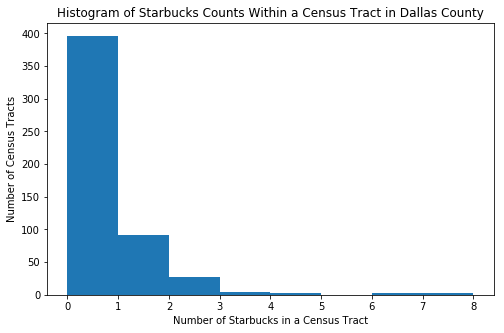

In [927]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(df_FINAL_dallas_analysis['Starbucks_Count'],bins=9)
print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

bins = np.linspace(0, 8, num=9)
df_FINAL_dallas_analysis['Starbucks_Count'].plot(kind='hist', figsize=(8, 5), bins=bins)

plt.title('Histogram of Starbucks Counts Within a Census Tract in Dallas County') # add a title to the histogram
plt.ylabel('Number of Census Tracts') # add y-label
plt.xlabel('Number of Starbucks in a Census Tract') # add x-label

plt.show()

In [497]:
df_hist_table = df_FINAL_dallas_analysis.groupby(['Starbucks_Count'],axis=0).count()
df_hist_table = pd.DataFrame(df_hist_table.iloc[:,0])
df_hist_table = df_hist_table.reset_index()
df_hist_table.columns = ['Starbucks Counts', 'Numnber of Census Tracts']
df_hist_table

,Starbucks Counts,Numnber of Census Tracts
0,0,396
1,1,92
2,2,27
3,3,5
4,4,3
5,6,2
6,7,1
7,8,1


__Box and Whisker Plots of data variables vs. Starbucks Counts__

In [486]:
starbucks_counts = df_FINAL_dallas_analysis['Starbucks_Count'].unique()
starbucks_counts = sorted(starbucks_counts)
print(starbucks_counts)

[0, 1, 2, 3, 4, 6, 7, 8]


In [406]:
df_columns = df_FINAL_dallas_analysis.columns[1:]
print(df_columns)

Index(['Total Population', 'Per Capita Income', 'Male Percentage',
       'Female Percentage', 'Age 18 to 24 Percentage',
       'Age 25 to 34 Percentage', 'Age 35 to 44 Percentage',
       'Age 45 to 54 Percentage', 'Age 55 to 64 Percentage',
       'Age 65 and Over Percentage', 'White Percentage', 'Hispanic Percentage',
       'Black Percentage', 'American Indian Percentage', 'Asian Percentage',
       'Native Hawaiian Percentage', 'Other Percentage',
       'Two or More Race Percentage'],
      dtype='object')


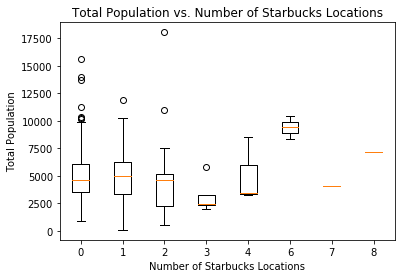

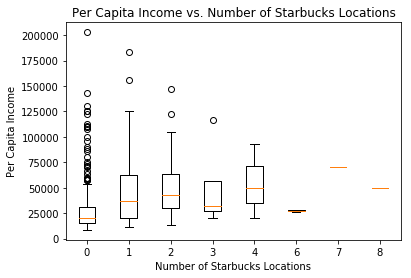

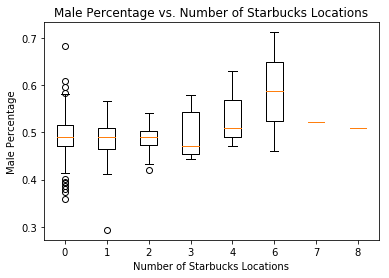

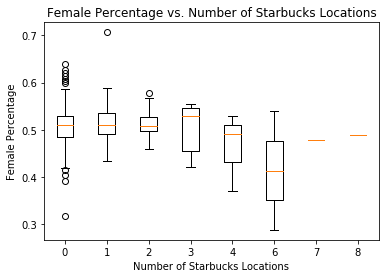

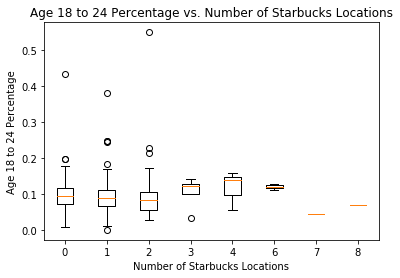

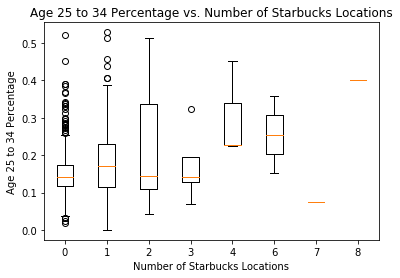

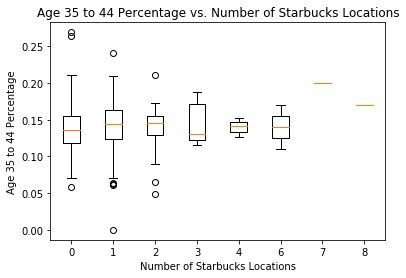

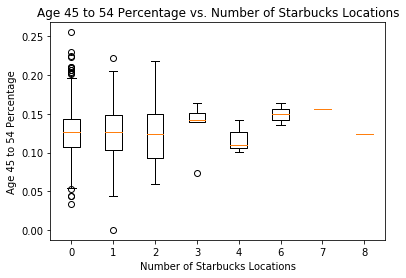

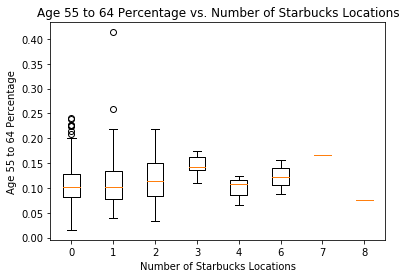

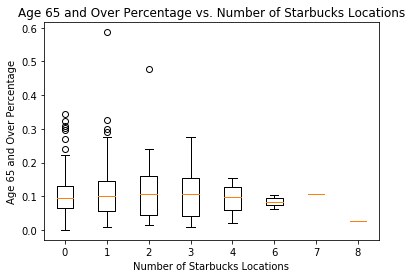

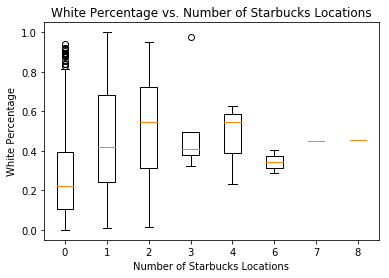

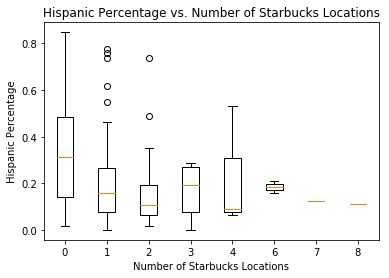

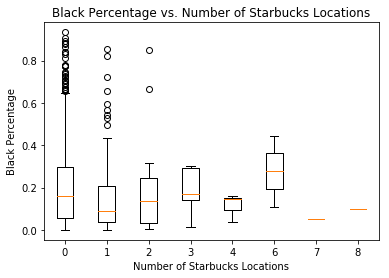

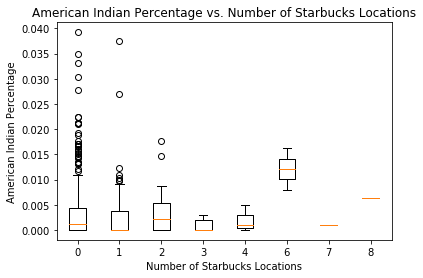

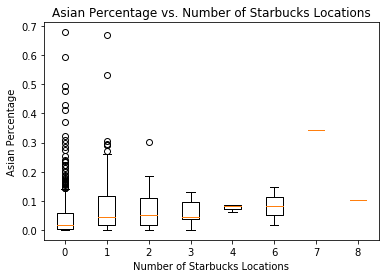

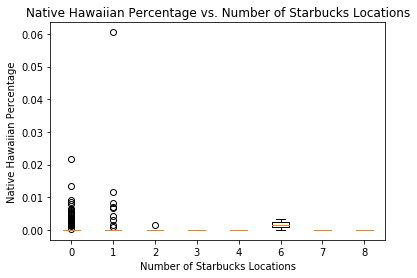

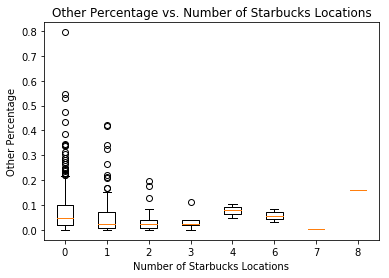

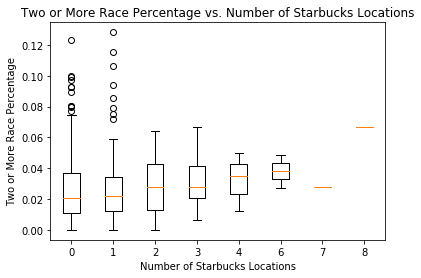

In [930]:
for column in df_columns:
    positions = [1]
    xticks = []
    fig = Figure()
    ax = plt.axes()
    for count in starbucks_counts:
        df_data = df_FINAL_dallas_analysis[df_FINAL_dallas_analysis['Starbucks_Count'] == count]
        df_data = df_data[column]
        bp = plt.boxplot(df_data, positions = positions, widths = 0.8)
        xticks.append(positions)
        positions = [x+2 for x in positions]
    
    plt.xlim(0,16)
    ax.set_xticklabels(starbucks_counts)
    ax.set_xticks(xticks)
    plt.ylabel(column)
    plt.xlabel('Number of Starbucks Locations')
    plt.title(column + ' vs. Number of Starbucks Locations')
    plt.show()

## 6. Model Development

Model was developed using the Dallas data set.

In [841]:
y = df_FINAL_dallas_analysis['Starbucks_Count']
x = df_FINAL_dallas_analysis[df_SB_strong_corr['Category']]

Preprocessing the Data

In [842]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(x).transform(x.astype(float))

C:\Users\trevo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Importing libraries for model generation.

In [843]:
from sklearn.model_selection import train_test_split # creatres test ant training set data.
from sklearn.linear_model import LinearRegression # creates linear regression model.

Evaluating different test to training set ratios.

In [844]:
test_size = list(np.arange(0.05,.75,0.05))
test_size

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.6500000000000001,
 0.7000000000000001]

In [845]:
# Function to test accuracy of data predictions.
def accuracy(y,yhat):
    length = len(y)
    counter = 0
    for n in range(length):
        if y[n] == yhat[n]:
            counter = counter + 1
    return counter/length

In [846]:
train_accuracy_list = []
train_score_list = []
train_avg_list = []
train_avg_predict_list = []
test_accuracy_list = []
test_score_list = []
test_avg_list = []
test_avg_predict_list = []
for test in test_size:
    # Splits training and test sets.
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test, random_state=4)
    
    # Creates linear model.
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    
    # yhat for training data
    yhat = lm.predict(X_train)
    yhat_whole = [round(y,0) for y in yhat]
    yhat_whole = list(map(int, yhat_whole))
    
    # Model Evaluation measures for training data
    y_train_list = list(y_train)
    train_accuracy = accuracy(y_train_list, yhat_whole)
    train_score = lm.score(X_train, y_train)
    train_avg = sum(y_train_list)/len(y_train_list)
    train_avg_predict = sum(yhat_whole)/len(yhat_whole)
    
    # yhat for test data
    yhat_test = lm.predict(X_test)
    yhat_test_whole = [round(y,0) for y in yhat_test]
    yhat_test_whole = list(map(int, yhat_test_whole))
    
    # Model Evaluation measures for test data
    y_test_list = list(y_test)
    test_accuracy = accuracy(y_test_list, yhat_test_whole)
    test_score = lm.score(X_test, y_test)
    test_avg = sum(y_test_list)/len(y_test_list)
    test_avg_predict = sum(yhat_test_whole)/len(yhat_test_whole)
    
    # saving model evaluation measures
    train_accuracy_list.append(train_accuracy)
    train_score_list.append(train_score)
    test_accuracy_list.append(test_accuracy)
    test_score_list.append(test_score)
    
    train_avg_list.append(train_avg)
    train_avg_predict_list.append(train_avg_predict)
    test_avg_list.append(test_avg)
    test_avg_predict_list.append(test_avg_predict)

In [847]:
model_eval = pd.DataFrame({'Test Data Size':test_size, 'Training Set Accuracy':train_accuracy_list,
                           'Training Set Score':train_score_list, 'Average Value of Training Set': train_avg_list,
                           'Average Value of Predicted Training Set': train_avg_predict_list,
                           'Test Set Accuracy':test_accuracy_list, 'Test Set Score':test_score_list,
                          'Average Value of Test Set': test_avg_list,
                           'Average Value of Predicted Test Set': test_avg_predict_list})
model_eval

,Test Data Size,Training Set Accuracy,Training Set Score,Average Value of Training Set,Average Value of Predicted Training Set,Test Set Accuracy,Test Set Score,Average Value of Test Set,Average Value of Predicted Test Set
0,0.05,0.700000,0.126073,0.370000,0.288000,0.740741,0.062896,0.555556,0.222222
1,0.10,0.704641,0.124340,0.354430,0.286920,0.641509,0.053076,0.603774,0.264151
2,0.15,0.689038,0.124081,0.364653,0.302013,0.687500,0.101560,0.462500,0.262500
3,0.20,0.700713,0.133715,0.370546,0.301663,0.669811,0.061563,0.415094,0.301887
4,0.25,0.696203,0.134958,0.379747,0.316456,0.681818,0.062347,0.378788,0.295455
5,0.30,0.692935,0.128889,0.388587,0.323370,0.666667,0.076931,0.358491,0.333333
6,0.35,0.675439,0.118491,0.394737,0.333333,0.675676,0.110955,0.351351,0.340541
7,0.40,0.686709,0.131577,0.392405,0.325949,0.715640,0.088010,0.360190,0.284360
8,0.45,0.681661,0.138502,0.411765,0.332180,0.693277,0.055905,0.340336,0.327731
9,0.50,0.692015,0.126955,0.395437,0.311787,0.678030,0.079734,0.363636,0.356061


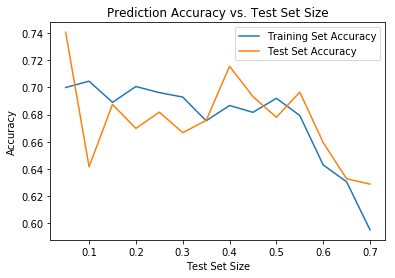

In [848]:
plt.plot(model_eval['Test Data Size'], model_eval['Training Set Accuracy'])
plt.plot(model_eval['Test Data Size'], model_eval['Test Set Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Test Set Size')
plt.title('Prediction Accuracy vs. Test Set Size')
plt.legend()

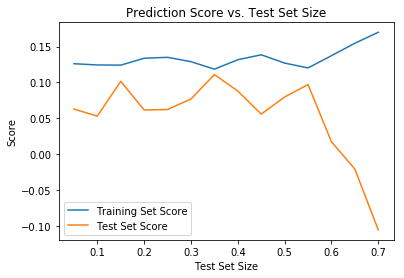

In [849]:
plt.plot(model_eval['Test Data Size'], model_eval['Training Set Score'])
plt.plot(model_eval['Test Data Size'], model_eval['Test Set Score'])
plt.ylabel('Score')
plt.xlabel('Test Set Size')
plt.title('Prediction Score vs. Test Set Size')
plt.legend()

No handles with labels found to put in legend.


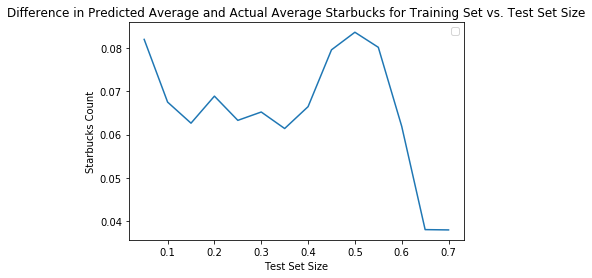

In [850]:
plt.plot(model_eval['Test Data Size'], model_eval['Average Value of Training Set'] - model_eval['Average Value of Predicted Training Set'])
plt.ylabel('Starbucks Count')
plt.xlabel('Test Set Size')
plt.title('Difference in Predicted Average and Actual Average Starbucks for Training Set vs. Test Set Size')
plt.legend()

No handles with labels found to put in legend.


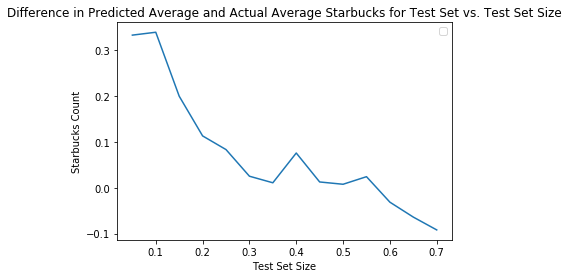

In [851]:
plt.plot(model_eval['Test Data Size'], model_eval['Average Value of Test Set'] - model_eval['Average Value of Predicted Test Set'])
plt.ylabel('Starbucks Count')
plt.xlabel('Test Set Size')
plt.title('Difference in Predicted Average and Actual Average Starbucks for Test Set vs. Test Set Size')
plt.legend()

Final model developed.

In [876]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=4)
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [877]:
lm.coef_

array([ 0.11744912,  0.20593696,  0.04146726, -0.0812194 ,  0.085946  ])

In [878]:
lm.intercept_

0.38998068002447944

In [879]:
yhat_d = lm.predict(X_train)
yhat_d_whole = [round(y,0) for y in yhat_d]
yhat_d_whole = list(map(int, yhat_d_whole))

Comparison of Actual vs. Predicted Value for Training set.

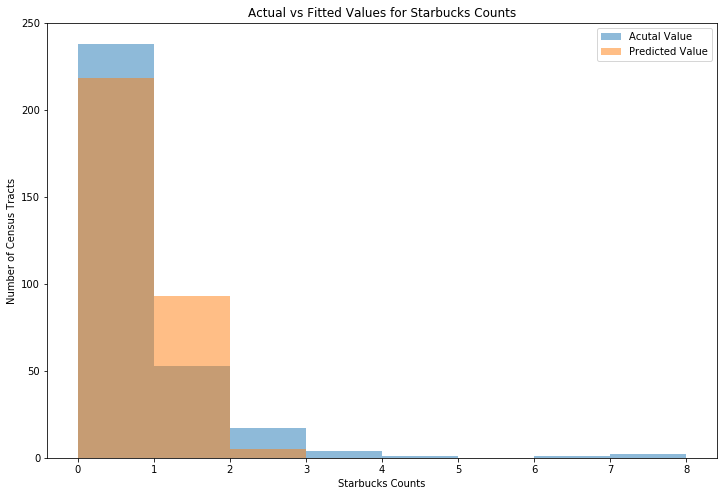

In [909]:
width = 12
height = 8
plt.figure(figsize=(width, height))

bins = np.linspace(0, 8, num=9)

plt.hist(y_train, bins, alpha=0.5, label='Acutal Value')
plt.hist(yhat_d_whole, bins, alpha=0.5, label='Predicted Value')
plt.legend(loc='upper right')

plt.title('Actual vs Fitted Values for Starbucks Counts')
plt.xlabel('Starbucks Counts')
plt.ylabel('Number of Census Tracts')

plt.show()

Comparison of Actual vs. Predicted Value for Test set.

In [911]:
yhat_d_test = lm.predict(X_test)
yhat_d_test_whole = [round(y,0) for y in yhat_d_test]
yhat_d_test_whole = list(map(int, yhat_d_test_whole))

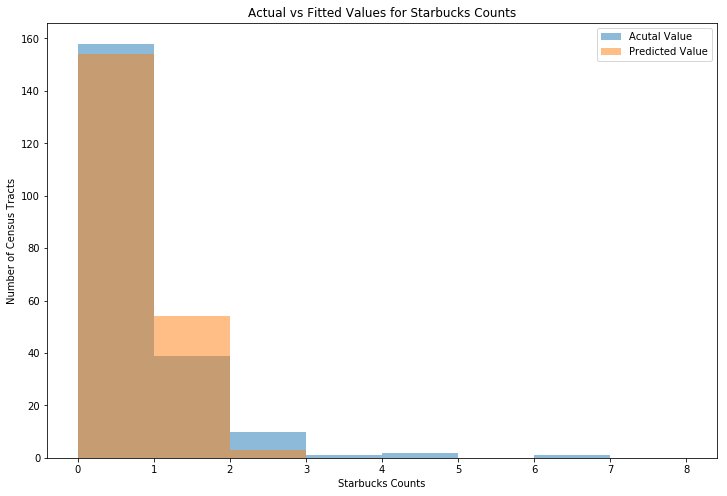

In [912]:
width = 12
height = 8
plt.figure(figsize=(width, height))

bins = np.linspace(0, 8, num=9)

plt.hist(y_test, bins, alpha=0.5, label='Acutal Value')
plt.hist(yhat_d_test_whole, bins, alpha=0.5, label='Predicted Value')
plt.legend(loc='upper right')

plt.title('Actual vs Fitted Values for Starbucks Counts')
plt.xlabel('Starbucks Counts')
plt.ylabel('Number of Census Tracts')

plt.show()

## 7. Model Performance in Tarrant County

In [855]:
y2 = df_FINAL_tarrant_analysis['Starbucks_Count']
x2 = df_FINAL_tarrant_analysis[df_SB_strong_corr['Category']]

In [856]:
X2 = preprocessing.StandardScaler().fit(x2).transform(x2.astype(float))

C:\Users\trevo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [913]:
yhat = lm.predict(X2)
yhat_whole = [round(y,0) for y in yhat]
yhat_whole = list(map(int, yhat_whole))

In [914]:
y2_list = list(y2)

In [915]:
accuracy(y2_list, yhat_whole)

0.6095505617977528

In [916]:
lm.score(X2,y2)

0.07151913461654269

In [917]:
sum(y2_list)/len(y2_list)

0.44662921348314605

In [918]:
sum(yhat_whole)/len(yhat_whole)

0.3258426966292135

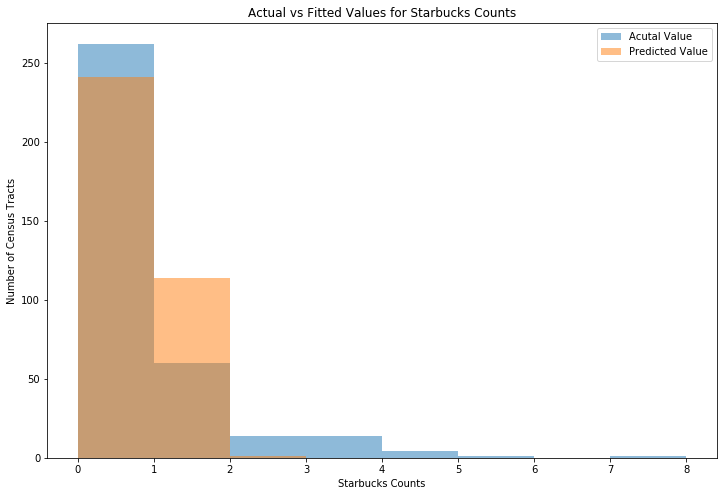

In [919]:
width = 12
height = 8
plt.figure(figsize=(width, height))

bins = np.linspace(0, 8, num=9)

plt.hist(y2, bins, alpha=0.5, label='Acutal Value')
plt.hist(yhat_whole, bins, alpha=0.5, label='Predicted Value')
plt.legend(loc='upper right')

plt.title('Actual vs Fitted Values for Starbucks Counts')
plt.xlabel('Starbucks Counts')
plt.ylabel('Number of Census Tracts')

plt.show()

In [924]:
df_hist_table2 = df_FINAL_tarrant_analysis.groupby(['Starbucks_Count'],axis=0).count()
df_hist_table2 = pd.DataFrame(df_hist_table2.iloc[:,0])
df_hist_table2 = df_hist_table2.reset_index()
df_hist_table2.columns = ['Starbucks Counts', 'Numnber of Census Tracts']
df_hist_table2

,Starbucks Counts,Numnber of Census Tracts
0,0,262
1,1,60
2,2,14
3,3,14
4,4,4
5,5,1
6,8,1


In [786]:
print(df_FINAL_tarrant_analysis.dtypes)

Starbucks_Count                  int64
Total Population                object
Per Capita Income               object
Male Percentage                float64
Female Percentage              float64
Age 18 to 24 Percentage        float64
Age 25 to 34 Percentage        float64
Age 35 to 44 Percentage        float64
Age 45 to 54 Percentage        float64
Age 55 to 64 Percentage        float64
Age 65 and Over Percentage     float64
White Percentage               float64
Hispanic Percentage            float64
Black Percentage               float64
American Indian Percentage     float64
Asian Percentage               float64
Native Hawaiian Percentage     float64
Other Percentage               float64
Two or More Race Percentage    float64
dtype: object


In [920]:
df_FINAL_tarrant_analysis = df_FINAL_tarrant_analysis.astype({'Total Population': 'int64', 'Per Capita Income':'int64'})

Checking correlation of census data in Tarrant county to the Starbucks Counts in each census tract.

In [921]:
df_corr2 = df_FINAL_tarrant_analysis.corr()
df_corr2

,Starbucks_Count,Total Population,Per Capita Income,Male Percentage,Female Percentage,Age 18 to 24 Percentage,Age 25 to 34 Percentage,Age 35 to 44 Percentage,Age 45 to 54 Percentage,Age 55 to 64 Percentage,Age 65 and Over Percentage,White Percentage,Hispanic Percentage,Black Percentage,American Indian Percentage,Asian Percentage,Native Hawaiian Percentage,Other Percentage,Two or More Race Percentage
Starbucks_Count,1.000000,0.197867,0.232906,-0.057637,0.057637,0.190439,0.075277,0.006536,0.030937,-0.019003,0.014978,0.183718,-0.193109,-0.092536,0.080419,0.153114,-0.008957,-0.156915,0.083749
Total Population,0.197867,1.000000,0.061453,-0.035884,0.035884,-0.044276,-0.085836,0.362001,0.078081,-0.214507,-0.314937,0.033979,-0.094583,-0.006592,0.046986,0.266983,-0.026092,-0.105701,0.133459
Per Capita Income,0.232906,0.061453,1.000000,-0.104739,0.104739,-0.273159,-0.265739,-0.040766,0.487012,0.516980,0.357994,0.759316,-0.626875,-0.393880,-0.117333,0.157119,-0.043740,-0.551224,-0.004513
Male Percentage,-0.057637,-0.035884,-0.104739,1.000000,-1.000000,0.073516,0.141307,0.032461,0.014630,-0.106012,-0.170921,-0.132429,0.202503,-0.121103,0.075584,0.097953,-0.037202,0.227547,-0.016088
Female Percentage,0.057637,0.035884,0.104739,-1.000000,1.000000,-0.073516,-0.141307,-0.032461,-0.014630,0.106012,0.170921,0.132429,-0.202503,0.121103,-0.075584,-0.097953,0.037202,-0.227547,0.016088
Age 18 to 24 Percentage,0.190439,-0.044276,-0.273159,0.073516,-0.073516,1.000000,0.214904,-0.198268,-0.406354,-0.364234,-0.302313,-0.252560,0.190401,0.121034,0.125499,0.082569,0.007023,0.155538,-0.007351
Age 25 to 34 Percentage,0.075277,-0.085836,-0.265739,0.141307,-0.141307,0.214904,1.000000,-0.078882,-0.461995,-0.383315,-0.283022,-0.235178,0.121682,0.194276,0.021263,0.030659,0.057794,0.095748,0.082100
Age 35 to 44 Percentage,0.006536,0.362001,-0.040766,0.032461,-0.032461,-0.198268,-0.078882,1.000000,0.054073,-0.298933,-0.449751,-0.111770,-0.004654,0.087889,0.001361,0.246966,0.017102,-0.014213,0.256976
Age 45 to 54 Percentage,0.030937,0.078081,0.487012,0.014630,-0.014630,-0.406354,-0.461995,0.054073,1.000000,0.271999,0.108198,0.371758,-0.349654,-0.184248,-0.027533,0.184601,-0.001617,-0.282091,0.037988
Age 55 to 64 Percentage,-0.019003,-0.214507,0.516980,-0.106012,0.106012,-0.364234,-0.383315,-0.298933,0.271999,1.000000,0.527587,0.566310,-0.394262,-0.335082,-0.053685,-0.055296,0.015534,-0.348606,-0.116225


In [922]:
corr_val2 = 0.1 # same as used by Dallas county

In [923]:
df_SB_strong_corr2 = df_corr2[((df_corr2 > corr_val2) | (df_corr2 < -corr_val2)) & (df_corr2 != 1)]
df_SB_strong_corr2 = df_SB_strong_corr2['Starbucks_Count']
df_SB_strong_corr2 = df_SB_strong_corr2.dropna(how='all')
df_SB_strong_corr2 = pd.DataFrame(df_SB_strong_corr2)
df_SB_strong_corr2 = df_SB_strong_corr2.reset_index()
df_SB_strong_corr2.columns = ['Category', 'Correlation to Starbucks Count']
df_SB_strong_corr2

,Category,Correlation to Starbucks Count
0,Total Population,0.197867
1,Per Capita Income,0.232906
2,Age 18 to 24 Percentage,0.190439
3,White Percentage,0.183718
4,Hispanic Percentage,-0.193109
5,Asian Percentage,0.153114
6,Other Percentage,-0.156915
